# Linear regression with Python: `bambi`, `pymc`, `arviz`, `loo`, and `preliz`

This workshop's goal—which is facilitated by this notebook—is to give attendees the confidence to conduct Bayesian regression analyses with `Python` for their research projects.

[`bambi`](https://bambinos.github.io/bambi/) is a high-level Bayesian model-building interface written in `Python`.

[`pymc`](https://www.pymc.io/welcome.html) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process.

[`arviz`](https://python.arviz.org/en/stable/index.html) is a `Python` package for exploratory analysis of Bayesian models.

[`loo`](https://mc-stan.org/loo/index.html) allows users to compute efficient approximate leave-one-out cross-validation for fitted Bayesian models, as well as model weights that can be used to average predictive distributions.

[`preliz`](https://preliz.readthedocs.io/en/latest/index.html) helps practitioners choose prior distributions by offering a set of tools for the various facets of prior elicitation. 

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html) and go through the various steps of conducting regression analyses in a [Bayesian workflow](https://arxiv.org/abs/2011.01808). Hopefully, you will come away feeling confident you can use `Python` to conduct regression analyses for your research projects.

# Table of Contents

## Linear regression with [`bambi`](https://bambinos.github.io/bambi/)

- ### An intercept

- ### A binary predictor

- ### A continuous predictor

- ### Two predictors (no interaction)

- ### Model comparison

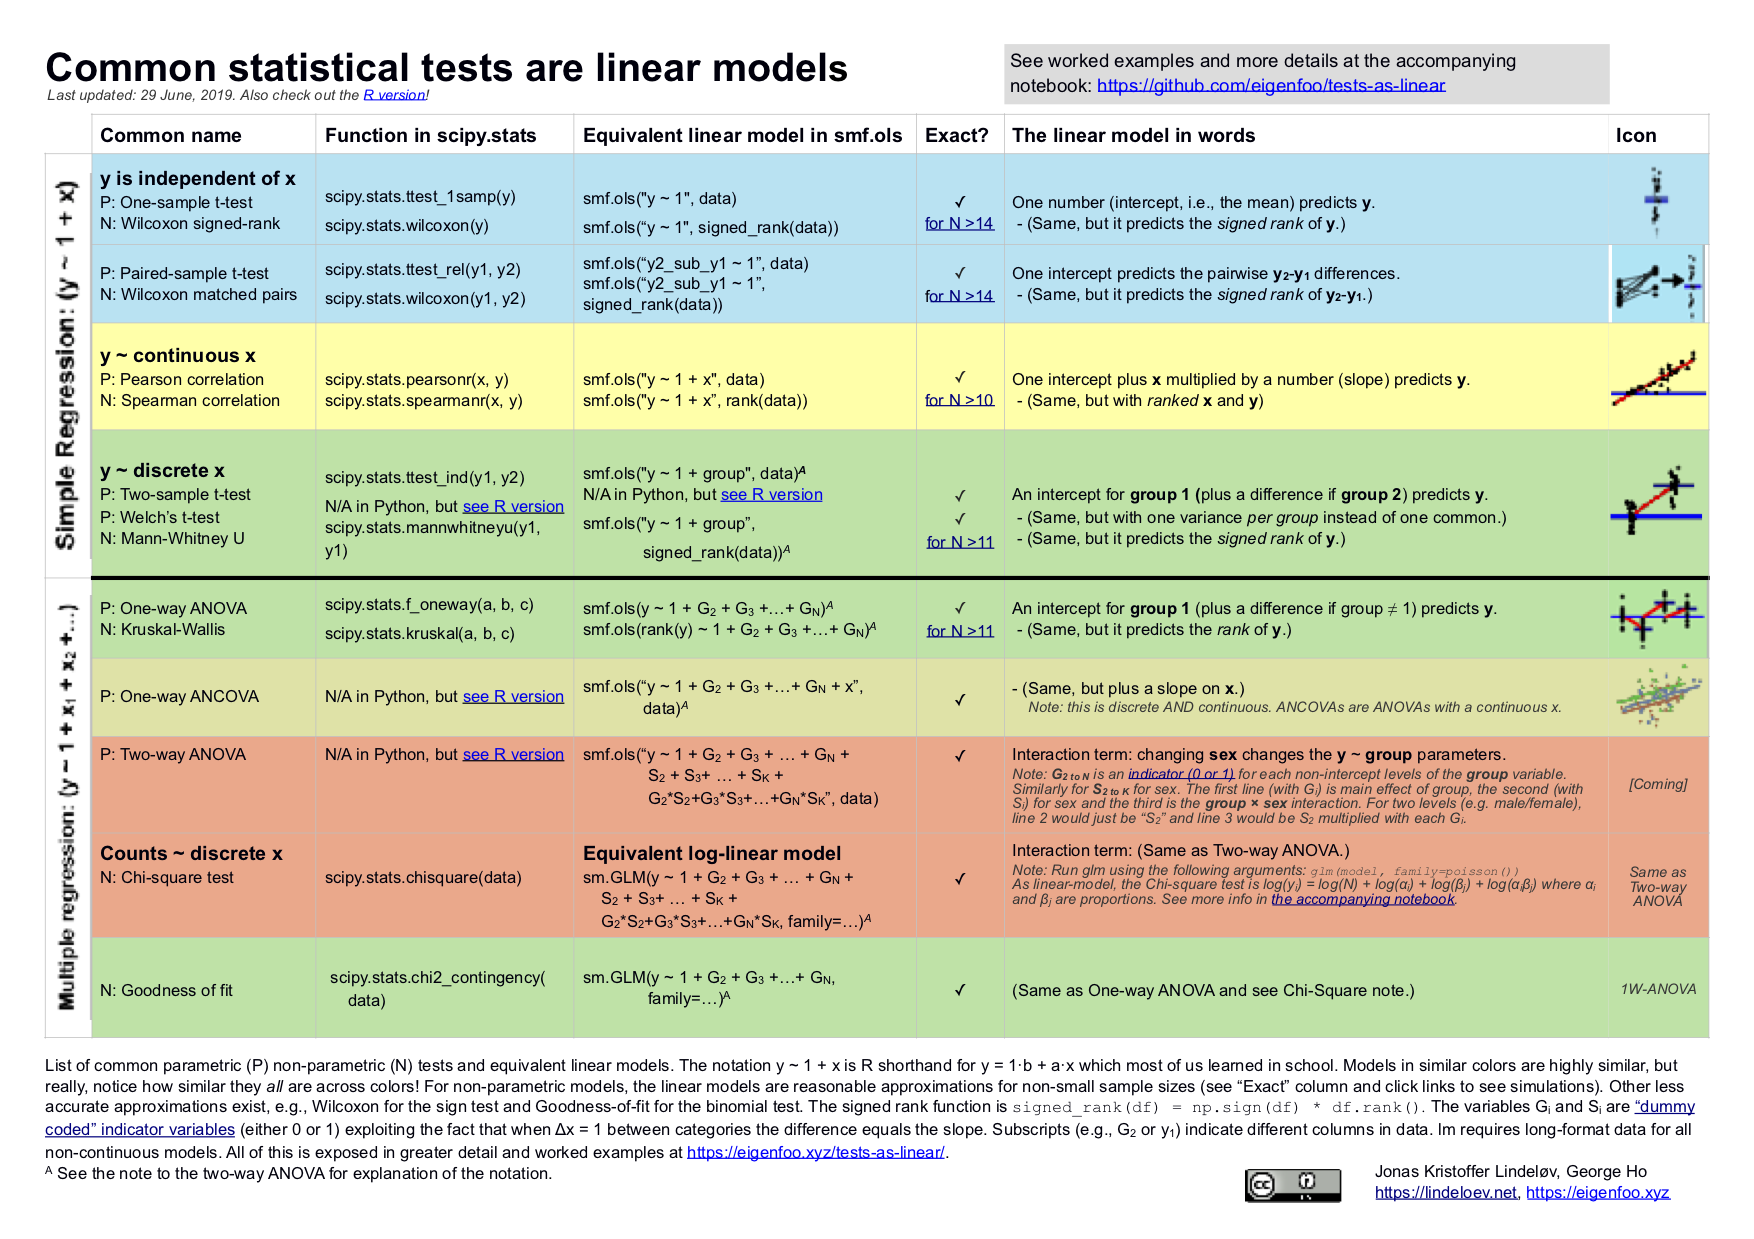

---

## Load packages

In [ ]:
%pip install arviz==0.22.0 bambi==0.16.0 preliz==0.22.0 pymc==5.26.1 --quiet

In [2]:
import logging

def silence_pytensor_warnings():
    """
    Suppress harmless PyTensor 'rewrite failure' and traceback messages
    that appear when building or graphing PyMC/Bambi models.
    Safe to call once per session or notebook.
    """
    
    class _SuppressPyTensorRewrite(logging.Filter):
        def filter(self, record):
            msg = record.getMessage()
            blocked_phrases = [
                "Rewrite failure due to:",
                "random_make_inplace",
                "Tensor type field must be a TensorType",
                "ERROR (pytensor.graph.rewriting.basic): node:",
                "ERROR (pytensor.graph.rewriting.basic): TRACEBACK",
                "TRACEBACK:",
                "RandomGeneratorType",
                "NoneTypeT"
            ]
            return not any(phrase in msg for phrase in blocked_phrases)

    for name in [
        "pytensor",
        "pytensor.graph.rewriting.basic",
        "pytensor.compile",
        "pytensor.tensor"
    ]:
        logger = logging.getLogger(name)
        logger.addFilter(_SuppressPyTensorRewrite())
        logger.setLevel(logging.ERROR)

    # Silence related packages
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("bambi").setLevel(logging.ERROR)

    print("✅ PyTensor rewrite and traceback warnings silenced.")

In [3]:
from datetime import datetime

import random
import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import pymc as pm
import bambi as bmb
import arviz as az
import preliz as pz

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pytensor")

print(f"Arviz: {az.__version__}")
print(f"Bambi: {bmb.__version__}")
print(f"Preliz: {pz.__version__}")
print(f"PyMC: {pm.__version__}")
md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Arviz: 0.22.0
Bambi: 0.16.0
Preliz: 0.22.0
PyMC: 5.26.1


Analysis last performed on 10/27/2025.

In [4]:
silence_pytensor_warnings()  # Call once per notebook/session

✅ PyTensor rewrite and traceback warnings silenced.


In [5]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
xr.set_options(display_expand_data=False, display_expand_attrs=False);

`display_expand_data=False` makes the default view for `xarray.DataArray` fold the data values to a single line. To explore the values, click on the DB icon on the left of the view, right under the `xarray.DataArray` text. It has no effect on `Dataset` objects that already default to folded views.

`display_expand_attrs=False` folds the attributes in both `DataArray` and `Dataset` objects to keep the views shorter. In this notebook we print `DataArrays` and `Datasets` several times, so let's fold the data values to a single line.

## List pre-defined style sheets provided by matplotlib:

In [6]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-doc',
 'arviz-docgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'preliz-doc',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Visualization in Bayesian workflow
- ### Plot data
- ### Plot model
- ### Plot prior parameter distributions
- ### Plot prior predictive distribution
- ### Plot MCMC diagnostics
- ### Plot posterior parameter distributions
- ### Plot posterior predictive distribution
- ### Plot model comparisons

## Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository](https://github.com/avehtari/ROS-Examples/tree/master). For this example, we're working with the `kidiq` dataset from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html).

In [7]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
kidiq = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2025ODSCWest/main/data/kidiq.csv')
kidiq.round(1)

kid_score  mom_hs  mom_iq  mom_work  mom_age
0           65       1   121.1         4       27
1           98       1    89.4         4       25
2           85       1   115.4         4       27
3           83       1    99.4         3       25
4          115       1    92.7         4       27
..         ...     ...     ...       ...      ...
429         94       0    84.9         4       21
430         76       1    93.0         4       23
431         50       0    94.9         2       24
432         88       1    96.9         2       21
433         70       1    91.3         2       25

[434 rows x 5 columns]

## Explore Data

In [8]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
kidiq.isna().sum()

kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

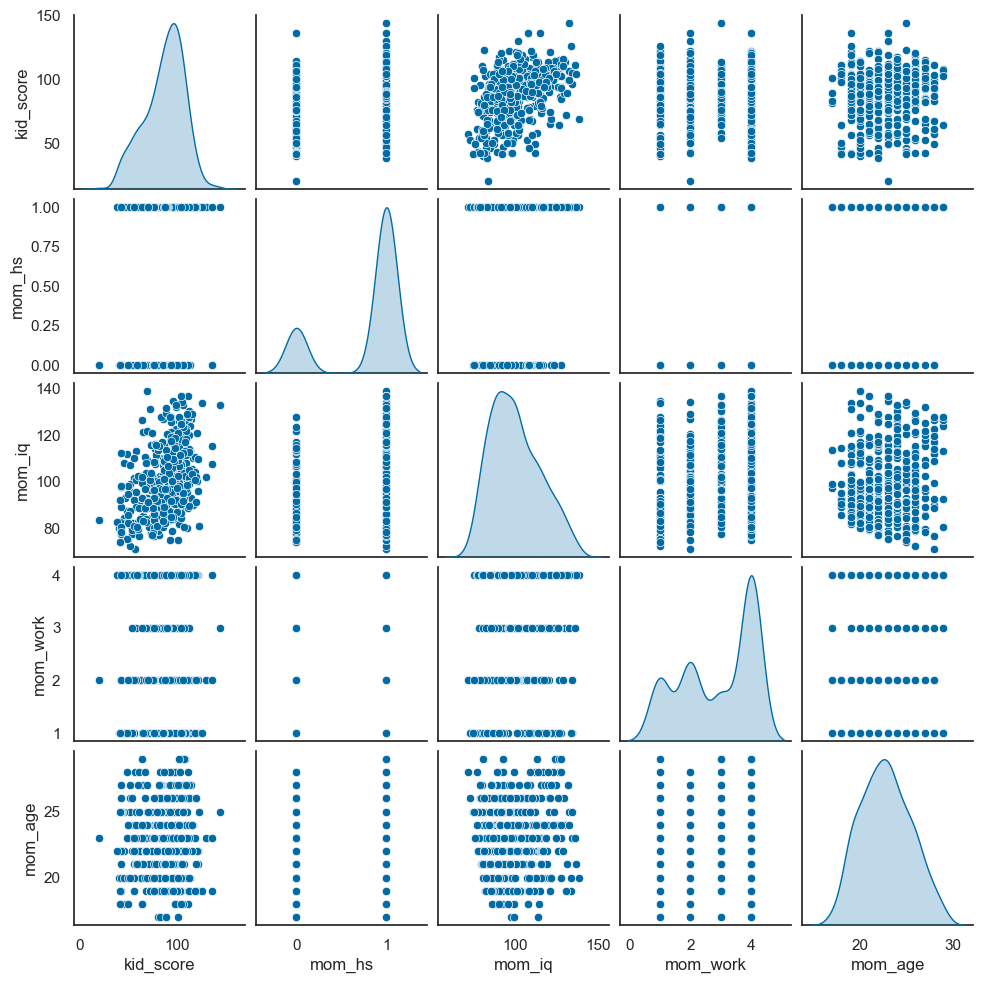

In [9]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(kidiq, diag_kind='kde', height=2, aspect=1);

In [10]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
kidiq.describe().round(decimals=1)  # transpose().round(decimals=1)

kid_score  mom_hs  mom_iq  mom_work  mom_age
count      434.0   434.0   434.0     434.0    434.0
mean        86.8     0.8   100.0       2.9     22.8
std         20.4     0.4    15.0       1.2      2.7
min         20.0     0.0    71.0       1.0     17.0
25%         74.0     1.0    88.7       2.0     21.0
50%         90.0     1.0    97.9       3.0     23.0
75%        102.0     1.0   110.3       4.0     25.0
max        144.0     1.0   138.9       4.0     29.0

In [11]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
statsmodels.stats.descriptivestats.describe(kidiq).round(2)

kid_score  mom_hs  mom_iq  mom_work  mom_age
nobs                 434.00  434.00  434.00    434.00   434.00
missing                0.00    0.00    0.00      0.00     0.00
mean                  86.80    0.79  100.00      2.90    22.79
std_err                0.98    0.02    0.72      0.06     0.13
upper_ci              88.72    0.82  101.41      3.01    23.04
lower_ci              84.88    0.75   98.59      2.79    22.53
std                   20.41    0.41   15.00      1.18     2.70
iqr                   28.00    0.00   21.61      2.00     4.00
iqr_normal            20.76    0.00   16.02      1.48     2.97
mad                   16.41    0.34   12.34      1.07     2.22
mad_normal            20.57    0.42   15.46      1.34     2.78
coef_var               0.24    0.52    0.15      0.41     0.12
range                124.00    1.00   67.86      3.00    12.00
max                  144.00    1.00  138.89      4.00    29.00
min                   20.00    0.00   71.04      1.00    17.00
skew                  -0.46   -1.39    0.47     -0.45     0.18
kurtosis               2.83    2.94    2.42      1.62     2.36
jarque_bera           15.88  140.35   21.80     48.95     9.65
jarque_bera_pval       0.00    0.00    0.00      0.00     0.01
mode                  94.00    1.00   97.60      4.00    23.00
mode_freq              0.04    0.79    0.01      0.47     0.15
median                90.00    1.00   97.92      3.00    23.00
1%                    41.00    0.00   75.02      1.00    18.00
5%                    49.00    0.00   79.36      1.00    19.00
10%                   56.30    0.00   81.68      1.00    19.00
25%                   74.00    1.00   88.66      2.00    21.00
50%                   90.00    1.00   97.92      3.00    23.00
75%                  102.00    1.00  110.27      4.00    25.00
90%                  110.00    1.00  121.83      4.00    26.00
95%                  114.35    1.00  127.58      4.00    27.00
99%                  125.01    1.00  134.45      4.00    29.00

---

# 1. An intercept (a column of 1s)

## Estimating a mean is the same as regressing on a constant term

We start by modeling the children's test scores with an intercept (a column of 1s), which summarizes the children's overall mean test score.  As shown by the coefficient for the Intercept, the children's overall mean test score is about 87.

## Plot data

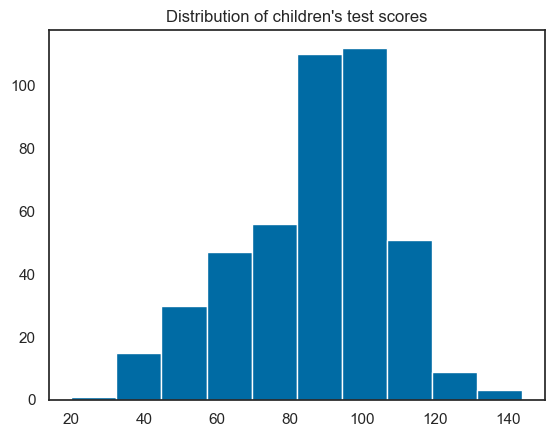

In [12]:
plt.hist(kidiq.kid_score)
plt.title("Distribution of children's test scores");

In [13]:
# Mean of children's test scores
np.round(kidiq.kid_score.mean(), 1)

np.float64(86.8)

In [14]:
# Standard deviation of children's test scores
np.round(kidiq.kid_score.std(), 1)

np.float64(20.4)

---

## Plot model

Produce a [graph](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.graph)viz Digraph from a built Bambi model.  

The graph shows that, in the model, `kid_score` is distributed as a normal, [Gaussian distribution](https://distribution-explorer.github.io/continuous/normal.html), with a mean (`Intercept`) that is also normally-distributed and a standard deviation (`sigma`) that is distributed has a [Half-Student-t distribution](https://distribution-explorer.github.io/continuous/halfstudent_t.html).

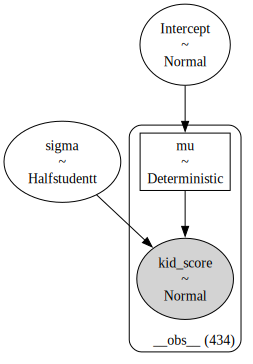

In [8]:
m1 = bmb.Model('kid_score ~ 1', data=kidiq)

m1.build()

m1.graph()

In [9]:
m1

       Formula: kid_score ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 50.9679)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

---

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

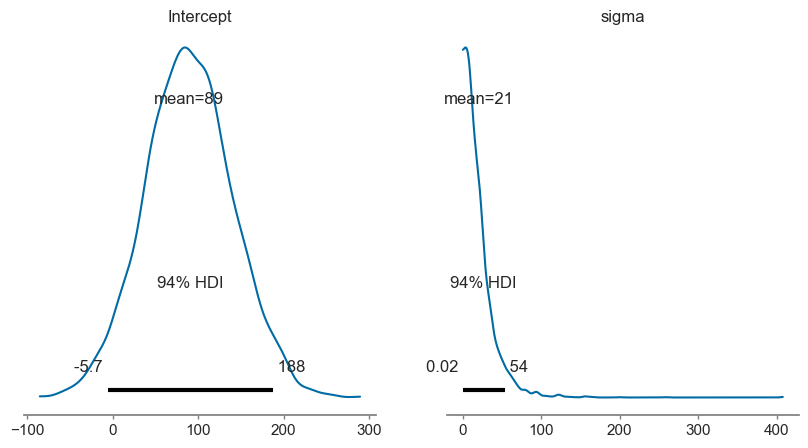

In [17]:
m1.plot_priors(figsize=(10,5));

### Using `preliz`

In [18]:
intercept = pz.Normal(mu=86.7972, sigma=50.9679)
intercept

Normal(mu=86.8, sigma=51)

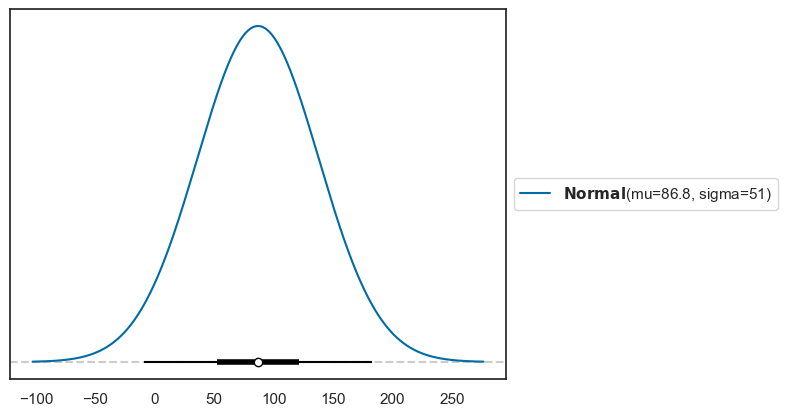

In [19]:
intercept.plot_pdf(pointinterval=True);

In [20]:
sigma = pz.HalfStudentT(nu=4.0, sigma=20.3872)
sigma

HalfStudentT(nu=4, sigma=20.4)

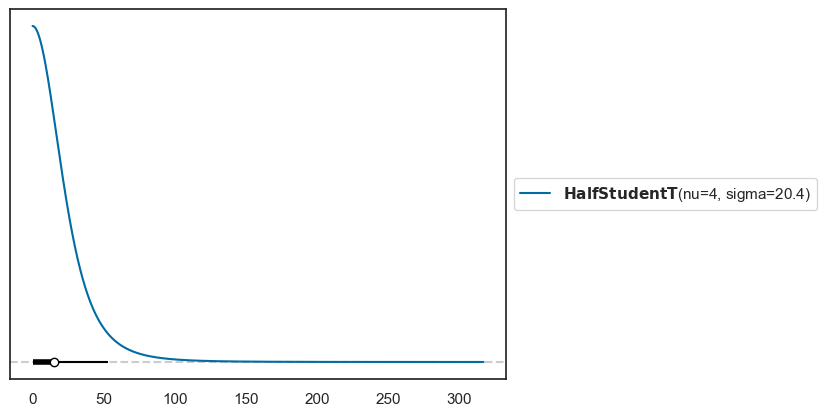

In [21]:
sigma.plot_pdf(pointinterval=True);

---

## Plot prior predictive distribution

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.prior_predictive`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.prior_predictive): Generate samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.prior_predictive) predictive distribution.

In [22]:
prior_pred = m1.prior_predictive()
prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [23]:
az.summary(prior_pred.prior_predictive, var_names=["kid_score"], kind="stats", round_to=1)

mean    sd  hdi_3%  hdi_97%
kid_score[0]    89.9  60.7   -11.7    190.5
kid_score[1]    89.2  57.2   -26.0    182.2
kid_score[2]    89.7  59.9    -5.9    195.6
kid_score[3]    87.9  61.8   -23.5    189.1
kid_score[4]    90.1  58.4   -20.7    186.6
...              ...   ...     ...      ...
kid_score[429]  90.4  59.1   -22.8    190.0
kid_score[430]  87.3  57.7   -16.7    189.3
kid_score[431]  87.6  57.1   -15.5    193.3
kid_score[432]  88.7  56.6   -12.1    199.0
kid_score[433]  88.3  57.7   -13.2    192.4

[434 rows x 4 columns]

In [24]:
kid_score_samples = prior_pred.prior_predictive['kid_score'].values.flatten()
kid_score_samples

array([163.93279595, 111.40058625, 173.09797068, ...,  73.61202889,
        62.68128801,  77.88499089], shape=(217000,))

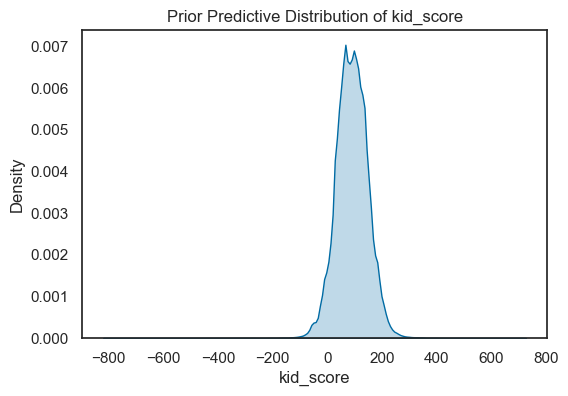

In [25]:
# Plot a KDE / PDF with seaborn
plt.figure(figsize=(6,4))
sns.kdeplot(kid_score_samples, fill=True)
plt.xlabel("kid_score")
plt.ylabel("Density")
plt.title("Prior Predictive Distribution of kid_score");

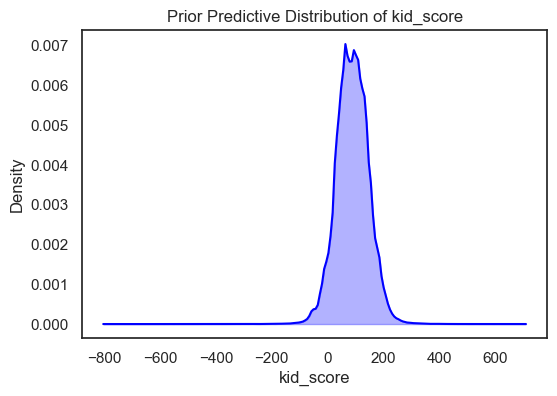

In [26]:
# Plot a KDE / PDF with scipy and matplotlib
kde = gaussian_kde(kid_score_samples)
x = np.linspace(kid_score_samples.min(), kid_score_samples.max(), 200)
plt.figure(figsize=(6,4))
plt.plot(x, kde(x), color='blue')
plt.fill_between(x, kde(x), alpha=0.3, color='blue')
plt.xlabel("kid_score")
plt.ylabel("Density")
plt.title("Prior Predictive Distribution of kid_score");

---

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [10]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m1_fit = m1.fit(idata_kwargs=dict(log_likelihood=True))

m1_fit

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# [Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

---

## Brief aside: working with `m1_fit` (our new `arviz.InferenceData` dataset)

In [28]:
m1_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Get the dataset corresponding to a single group

In [29]:
post = m1_fit.posterior
post

<xarray.Dataset> Size: 72kB
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    sigma      (chain, draw) float64 32kB 20.75 20.87 20.87 ... 19.76 20.94
    Intercept  (chain, draw) float64 32kB 86.41 85.99 85.99 ... 87.78 87.73
Attributes: (8)

### Combine chains and draws

In [30]:
stacked = az.extract(m1_fit)
stacked

<xarray.Dataset> Size: 160kB
Dimensions:    (sample: 4000)
Coordinates:
  * sample     (sample) object 32kB MultiIndex
  * chain      (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw       (sample) int64 32kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    sigma      (sample) float64 32kB 20.75 20.87 20.87 ... 20.73 19.76 20.94
    Intercept  (sample) float64 32kB 86.41 85.99 85.99 ... 85.59 87.78 87.73
Attributes: (8)

### Get a random subset of the samples

In [31]:
az.extract(m1_fit, num_samples=100)

<xarray.Dataset> Size: 4kB
Dimensions:    (sample: 100)
Coordinates:
  * sample     (sample) object 800B MultiIndex
  * chain      (sample) int64 800B 2 3 2 1 2 2 3 1 2 1 3 ... 2 1 1 0 1 1 1 2 0 0
  * draw       (sample) int64 800B 409 711 945 862 904 62 ... 119 401 758 571 72
Data variables:
    sigma      (sample) float64 800B 20.75 20.4 20.16 ... 20.24 20.39 20.02
    Intercept  (sample) float64 800B 87.4 87.22 85.5 85.72 ... 85.76 87.68 88.48
Attributes: (8)

### Obtain a NumPy array for a given parameter

In [32]:
stacked.Intercept.values

array([86.41085716, 85.99448446, 85.99448446, ..., 85.59176237,
       87.78284696, 87.73186752], shape=(4000,))

In [33]:
stacked.sigma.values

array([20.74962595, 20.86553416, 20.86553416, ..., 20.72662827,
       19.76024643, 20.94122948], shape=(4000,))

### Rename parameters

In [34]:
# Assign to new variable because renaming interferes with later step:
# posterior_predictive = m1.predict(m1_fit, kind="response")
m1_fit_renamed = m1_fit.rename_vars({"Intercept": "mu", "kid_score_sigma": "sigma"})
m1_fit_renamed

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Convert to a pandas DataFrame

In [35]:
m1_df = az.extract(m1_fit).to_dataframe() # [['Intercept', 'sigma']]
m1_df.round(2)

sigma  Intercept  chain  draw
chain draw                               
0     0     20.75      86.41      0     0
      1     20.87      85.99      0     1
      2     20.87      85.99      0     2
      3     19.41      86.45      0     3
      4     20.94      87.21      0     4
...           ...        ...    ...   ...
3     995   20.38      84.37      3   995
      996   20.89      88.92      3   996
      997   20.73      85.59      3   997
      998   19.76      87.78      3   998
      999   20.94      87.73      3   999

[4000 rows x 4 columns]

---

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

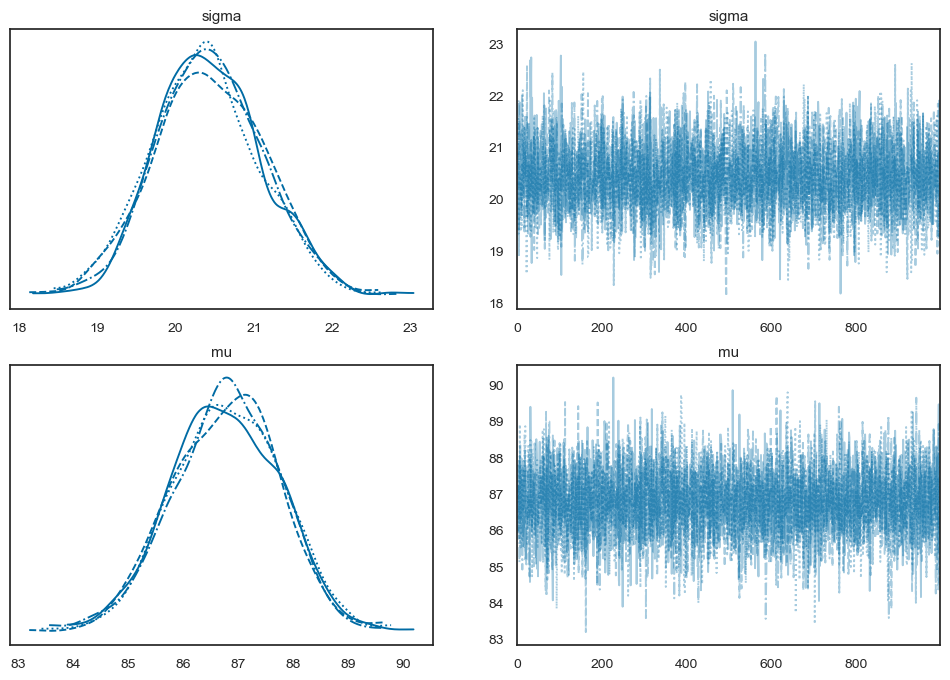

In [36]:
az.plot_trace(m1_fit_renamed, figsize=(12,8));

---

## Plot posterior parameter distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

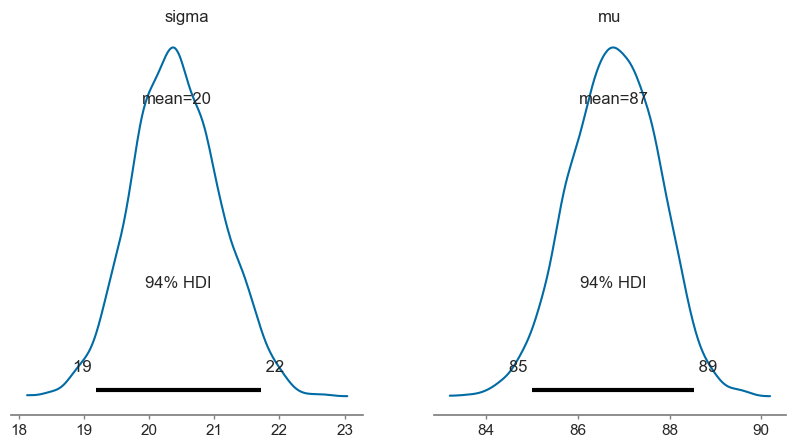

In [37]:
az.plot_posterior(m1_fit_renamed, figsize=(10,5));

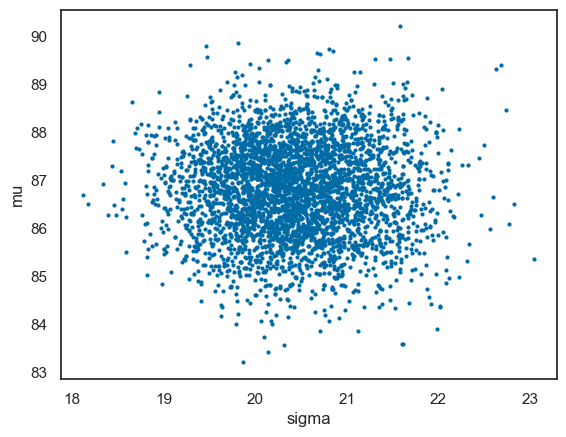

In [38]:
az.plot_pair(m1_fit_renamed);

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [39]:
az.summary(m1_fit_renamed, kind="all", round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  20.42  0.68   19.19    21.72       0.01     0.01   3713.61   2907.46   
mu     86.78  0.97   85.00    88.54       0.01     0.01   4452.39   2967.05   

       r_hat  
sigma    1.0  
mu       1.0

### Convert to a pandas DataFrame

In [40]:
# m1_df = az.extract_dataset(m1_fit).to_dataframe() # [['Intercept', 'sigma']]

m1_df = az.extract(m1_fit_renamed).to_dataframe()[['mu', 'sigma']]
m1_df.round(2)

mu  sigma
chain draw              
0     0     86.41  20.75
      1     85.99  20.87
      2     85.99  20.87
      3     86.45  19.41
      4     87.21  20.94
...           ...    ...
3     995   84.37  20.38
      996   88.92  20.89
      997   85.59  20.73
      998   87.78  19.76
      999   87.73  20.94

[4000 rows x 2 columns]

### Recover/Compute the estimates (mean) and standard errors (sd) "by hand"

In [41]:
print(f"mu mean: {np.round(m1_df['mu'].mean(), 2)} sd: {np.round(m1_df['mu'].std(), 2)}")

print(f"sigma mean: {np.round(m1_df['sigma'].mean(), 2)} sd: {np.round(m1_df['sigma'].std(), 2)}")

m1_df.describe().T.round(2)

mu mean: 86.78 sd: 0.97
sigma mean: 20.42 sd: 0.68


count   mean   std    min    25%    50%    75%    max
mu     4000.0  86.78  0.97  83.20  86.12  86.79  87.47  90.20
sigma  4000.0  20.42  0.68  18.13  19.95  20.40  20.87  23.04

In [42]:
m1_df.cov()

mu     sigma
mu     0.940631 -0.006469
sigma -0.006469  0.466510

In [43]:
# m1_fit.posterior["Intercept"][0][:10] # .to_pandas() or .to_series()

m1_fit_renamed.posterior["mu"][0][:10] # .to_pandas() or .to_series()

<xarray.DataArray 'mu' (draw: 10)> Size: 80B
86.41 85.99 85.99 86.45 87.21 87.21 87.35 88.34 85.52 85.56
Coordinates:
    chain    int64 8B 0
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9

In [44]:
# m1_fit.posterior["kid_score_sigma"][0][:10]

m1_fit_renamed.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)> Size: 80B
20.75 20.87 20.87 19.41 20.94 20.94 21.87 19.66 20.16 19.86
Coordinates:
    chain    int64 8B 0
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9

In [45]:
stats.multivariate_normal.rvs(mean=m1_df.mean(), cov=m1_df.cov(), size=10)

array([[88.7531261 , 21.48826287],
       [87.01273294, 20.37500817],
       [86.48682655, 20.7825904 ],
       [86.64407628, 22.22553731],
       [87.53648763, 20.62401821],
       [87.96739469, 19.77635367],
       [84.74798473, 20.67388622],
       [85.97920967, 20.8658695 ],
       [87.27446247, 19.49459333],
       [86.08323479, 19.72804655]])

---

## Plot posterior predictive distribution

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"response_params"` or `"response"`. The first returns draws from the posterior distribution of the likelihood parameters, while the latter returns the draws from the posterior predictive distribution (i.e. the posterior probability distribution for a new observation) in addition to the posterior distribution. Defaults to `"response_params"`.

In [46]:
posterior_predictive = m1.predict(m1_fit, kind="response")
m1_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

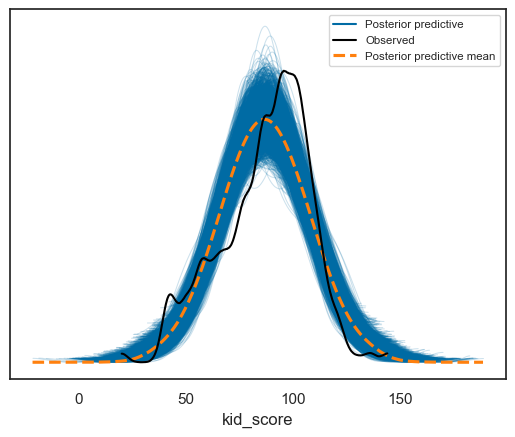

In [47]:
az.plot_ppc(m1_fit);

In [48]:
az.summary(m1_fit.posterior_predictive, var_names=["kid_score"], kind="stats", round_to=1)

mean    sd  hdi_3%  hdi_97%
kid_score[0]    87.3  20.3    49.0    126.5
kid_score[1]    86.6  20.7    48.8    127.0
kid_score[2]    86.3  20.5    47.9    124.6
kid_score[3]    86.4  20.2    48.1    124.0
kid_score[4]    86.7  20.6    45.0    122.4
...              ...   ...     ...      ...
kid_score[429]  86.8  20.6    50.0    126.9
kid_score[430]  87.1  20.3    51.1    126.8
kid_score[431]  86.5  20.4    48.6    125.3
kid_score[432]  86.9  20.0    50.1    124.3
kid_score[433]  86.9  20.5    47.1    123.4

[434 rows x 4 columns]

---

## Out-of-sample predictive performance

Having built a Bayesian model, you want to check how well it predicts new data —- how well it would do if you saw new observations. That's the idea of cross-validation: test the model's predictive performance on "left-out" data points. LOO stands for Leave-One-Out. In classical LOO:
- You leave out one observation from your dataset.
- Fit the model on the remaining data.
- See how well the model predicts the left-out point.
- Repeat for all data points.

This gives you an estimate of how your model generalizes to new data. For Bayesian models, refitting the model n times (for n observations) would be very slow. Instead, we use importance sampling:
- After fitting the model once to all the data, we can approximate the leave-one-out predictive densities without refitting.
- Standard importance sampling can be unstable if some weights are extreme.
- PSIS = Pareto Smoothed Importance Sampling: a smart way to smooth out extreme weights to make the approximation more stable.

So PSIS-LOO is a fast, robust way to approximate leave-one-out cross-validation for Bayesian models. 

The ArviZ function `az.loo()` does all of this for you:
- Takes your posterior samples and computes approximate LOO.

Returns:
- `loo`: the estimated expected log predictive density (elpd_loo), a measure of predictive fit.
- `p_loo`: an effective number of parameters (similar to model complexity).
- Diagnostics (Pareto k values) that tell you whether the approximation is reliable for each data point.

#### Why use it

- Model comparison: Compare multiple models’ predictive accuracy. Higher loo → better predictive performance.
- Check influential points: High Pareto k values indicate data points that are hard to predict and may need attention.
- Avoid overfitting: LOO penalizes models that fit the training data too closely but fail to generalize.

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [49]:
loo1 = az.loo(m1_fit)
loo1

Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1926.20    14.16
p_loo        1.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      434  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

# An index variable (or a binary indicator)

### Estimating a difference is the same as regressing on an indicator variable (Student's two-sample t-test)

## Summarize variables

In [50]:
kidiq.groupby('mom_hs')['kid_score'].describe().round(1)

count  mean   std   min   25%   50%    75%    max
mom_hs                                                   
0        93.0  77.5  22.6  20.0  58.0  80.0   95.0  136.0
1       341.0  89.3  19.0  38.0  77.0  92.0  103.0  144.0

## Plot data

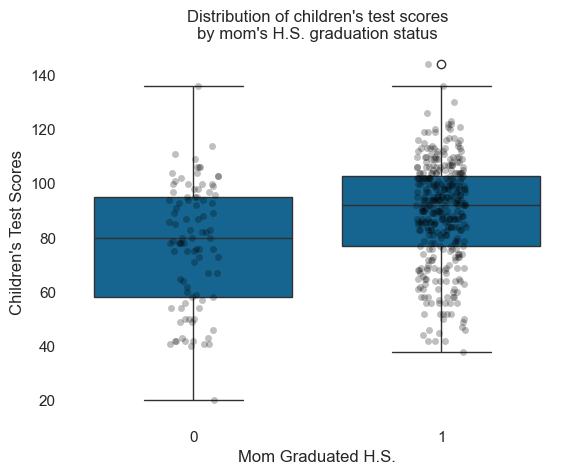

In [51]:
sns.boxplot(x='mom_hs', y='kid_score', data=kidiq)
sns.stripplot(x='mom_hs', y='kid_score', data=kidiq, color='black', alpha=0.25)
sns.despine(left=True, bottom=True)
plt.xlabel('Mom Graduated H.S.')
plt.ylabel('Children\'s Test Scores')
plt.title("Distribution of children's test scores\nby mom's H.S. graduation status");

In [52]:
sns.set_style("whitegrid")

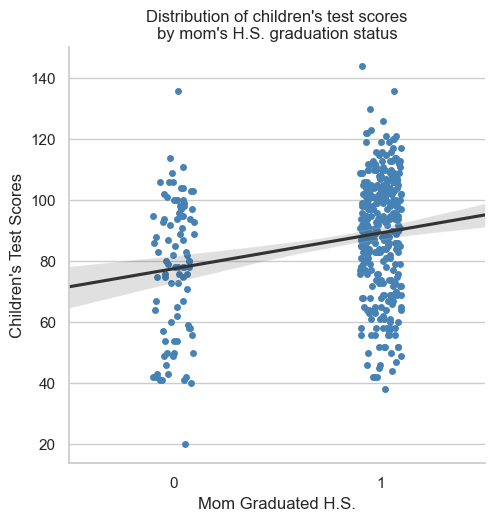

In [53]:
sns.catplot(data=kidiq, x="mom_hs", y="kid_score", color="steelblue", zorder=1)
sns.regplot(data=kidiq, x="mom_hs", y="kid_score", scatter=False, truncate=False, color=".2")
#sns.despine(left=True, bottom=True)
plt.xlabel('Mom Graduated H.S.')
plt.ylabel('Children\'s Test Scores')
plt.title("Distribution of children's test scores\nby mom's H.S. graduation status");

## Plot model

In [54]:
# kidiq['mom_hs'] = kidiq.mom_hs.astype('category')

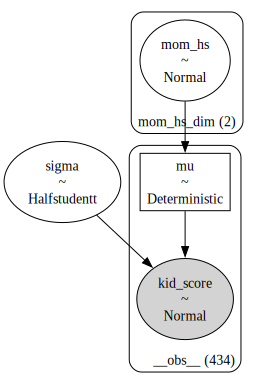

In [11]:
m2 = bmb.Model('kid_score ~ 0 + mom_hs', data=kidiq, categorical=['mom_hs'])

m2.build()

m2.graph()

In [12]:
m2

       Formula: kid_score ~ 0 + mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            mom_hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [57]:
az.style.use('arviz-darkgrid')

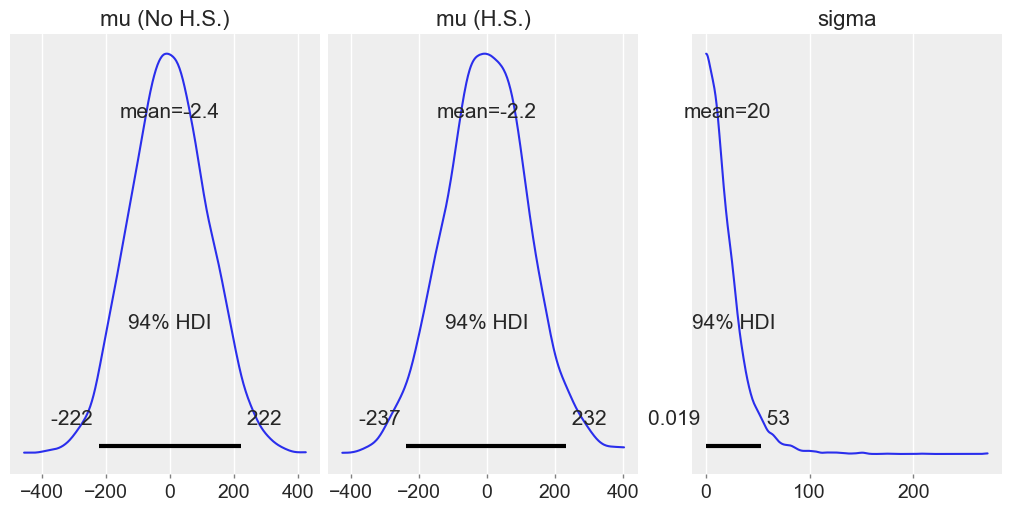

In [58]:
axs = m2.plot_priors(var_names=['mom_hs', 'sigma'], figsize=(10,5))

titles = ['mu (No H.S.)', 'mu (H.S.)', 'sigma']
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i]);

## Fit model

In [13]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m2_fit = m2.fit(idata_kwargs=dict(log_likelihood=True))

m2_fit

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [60]:
#m2_fit_renamed = m2_fit.rename_vars({"mom_hs": "mu", "kid_score_sigma": "sigma"})
#m2_fit_renamed

## Plot MCMC diagnostics

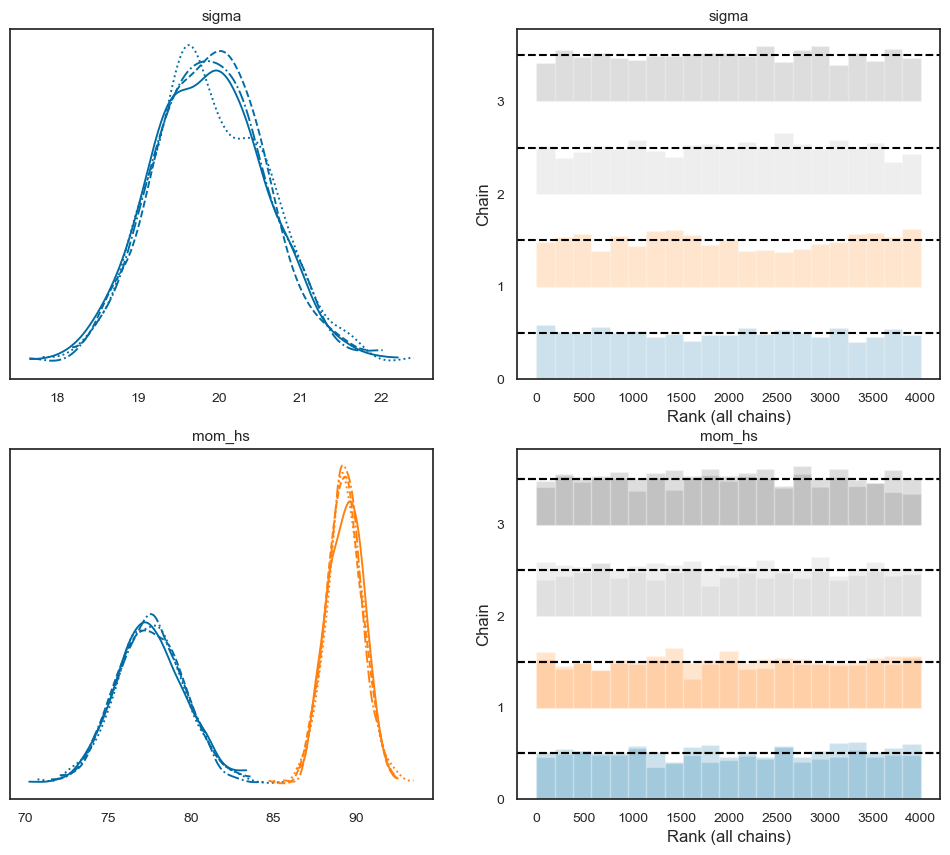

In [15]:
az.plot_trace(m2_fit, kind="rank_bars", figsize=(12,10));

## Plot posterior distributions

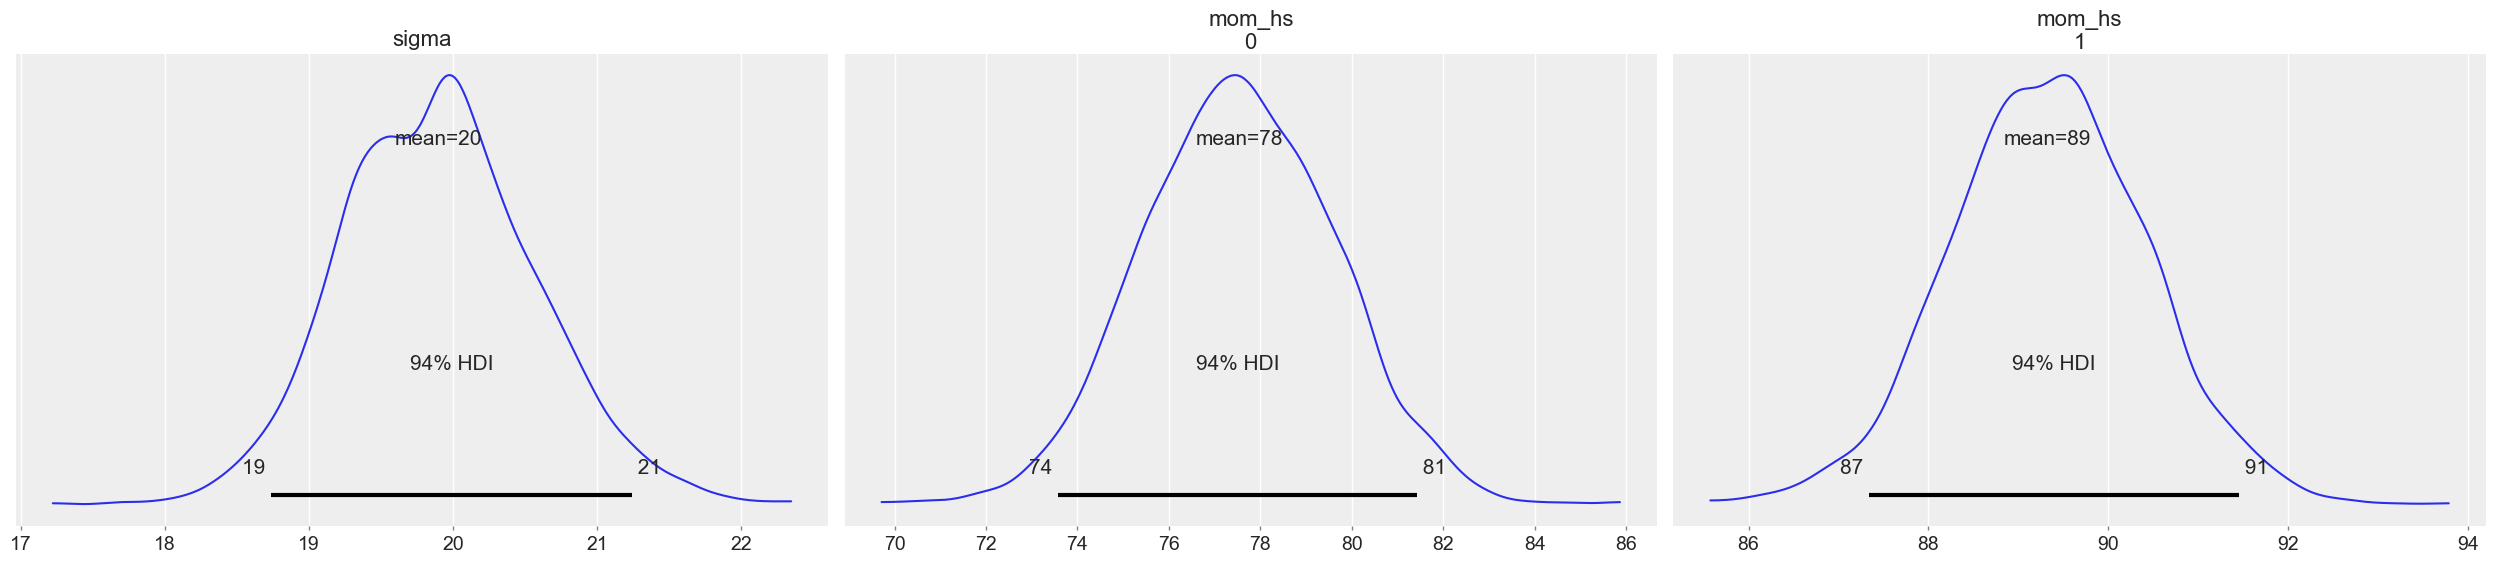

In [62]:
az.plot_posterior(m2_fit);

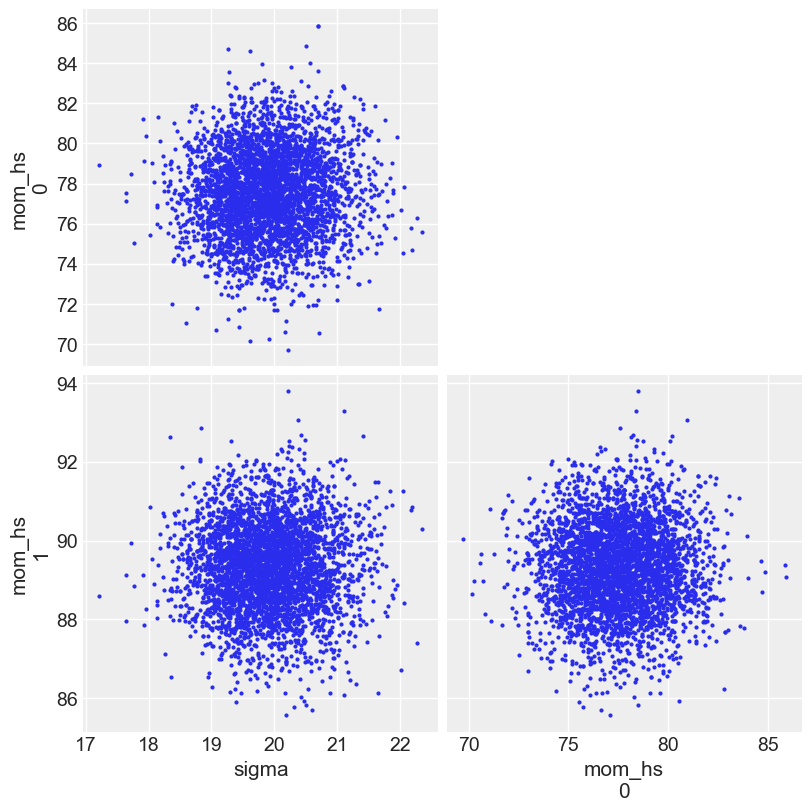

In [63]:
az.plot_pair(m2_fit, figsize=(8,8));

In [64]:
m2_df = az.extract(m2_fit).to_dataframe()[['mom_hs', 'sigma']].unstack(level=0)
m2_df

mom_hs                                       sigma  \
chain                    0          1          2          3          0   
draw mom_hs_dim                                                          
0    0           73.484084  79.052607  77.293549  72.841744  19.110530   
     1           89.060832  90.138935  89.290682  90.784157  19.110530   
1    0           79.093644  75.992412  76.220408  81.514681  21.634548   
     1           90.147722  88.125908  89.522779  90.253828  21.634548   
2    0           74.463435  80.913522  77.811820  73.139323  18.462304   
...                    ...        ...        ...        ...        ...   
997  1           89.787476  90.313560  89.568591  89.654092  20.520395   
998  0           78.462508  77.194182  75.757861  80.791466  20.553802   
     1           89.125621  88.240672  89.887139  89.953175  20.553802   
999  0           78.103460  77.798857  80.162544  77.578790  20.921840   
     1           91.634436  90.430271  89.641716  88.220682  20.921840   

                                                  
chain                    1          2          3  
draw mom_hs_dim                                   
0    0           21.241166  20.183097  20.098166  
     1           21.241166  20.183097  20.098166  
1    0           18.766297  20.157926  20.108480  
     1           18.766297  20.157926  20.108480  
2    0           19.080026  19.711485  19.565954  
...                    ...        ...        ...  
997  1           19.661029  21.645704  19.696659  
998  0           20.012335  19.580808  20.206476  
     1           20.012335  19.580808  20.206476  
999  0           19.643257  19.888622  19.718004  
     1           19.643257  19.888622  19.718004  

[2000 rows x 8 columns]

In [65]:
m2_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
       chain                                                        
mom_hs 0      2000.0  83.42  6.16  70.56  77.61  85.63  89.38  92.69
       1      2000.0  83.41  6.14  69.70  77.47  85.22  89.30  93.80
       2      2000.0  83.41  6.13  70.25  77.46  84.80  89.29  92.54
       3      2000.0  83.47  6.09  70.17  77.53  85.90  89.37  93.30
sigma  0      2000.0  19.90  0.67  17.65  19.42  19.88  20.32  22.05
       1      2000.0  19.91  0.67  18.08  19.43  19.90  20.37  21.89
       2      2000.0  19.88  0.67  17.22  19.44  19.89  20.27  22.27
       3      2000.0  19.89  0.67  17.64  19.41  19.89  20.32  22.35

## Interpret results

In [66]:
az.summary(m2_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma      19.9  0.7    18.7     21.2        0.0      0.0    6522.0    3003.0   
mom_hs[0]  77.5  2.1    73.6     81.4        0.0      0.0    6419.0    2807.0   
mom_hs[1]  89.3  1.1    87.3     91.5        0.0      0.0    6020.0    2977.0   

           r_hat  
sigma        1.0  
mom_hs[0]    1.0  
mom_hs[1]    1.0

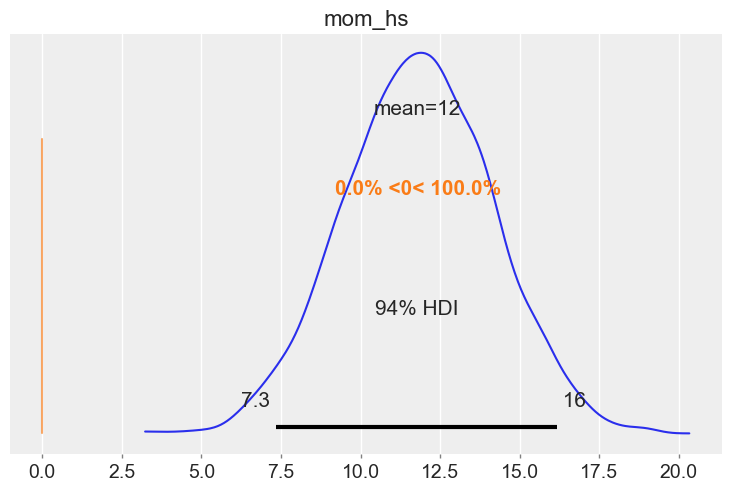

In [67]:
post_mom_hs = m2_fit.posterior["mom_hs"]

diff = post_mom_hs.sel(mom_hs_dim="1") - post_mom_hs.sel(mom_hs_dim="0")

az.plot_posterior(diff, ref_val=0);

In [68]:
# Probabiliy that posterior is > 0
(post_mom_hs > 0).mean().item()

1.0

In [69]:
posterior_predictive = m2.predict(m2_fit, kind="response")
m2_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

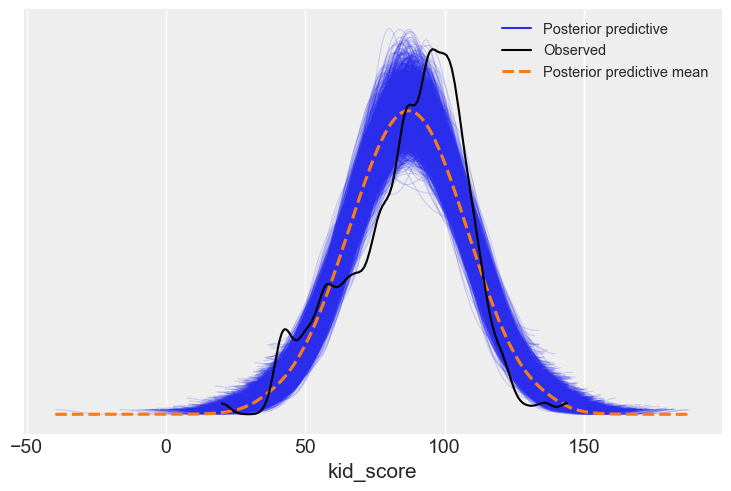

In [70]:
az.plot_ppc(m2_fit);

In [71]:
loo2 = az.loo(m2_fit)
loo2

Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1914.85    13.78
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      434  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Double-check with another [model](https://bambinos.github.io/bambi/notebooks/t-test.html#model-1)

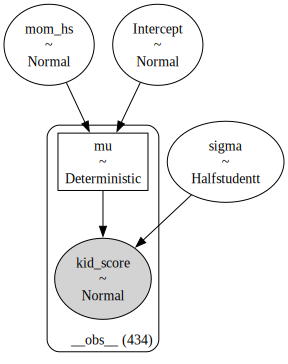

In [135]:
m2b = bmb.Model('kid_score ~ 1 + mom_hs', data=kidiq)

m2b.build()

m2b.graph()

In [136]:
m2b

       Formula: kid_score ~ 1 + mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

In [137]:
m2b_fit = m2b.fit()
m2b_fit

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [138]:
az.summary(m2b_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma      19.9  0.7    18.6     21.2        0.0      0.0    6234.0    2987.0   
Intercept  77.6  2.1    73.8     81.5        0.0      0.0    6328.0    3043.0   
mom_hs     11.8  2.3     7.1     15.9        0.0      0.0    5961.0    3292.0   

           r_hat  
sigma        1.0  
Intercept    1.0  
mom_hs       1.0

In [139]:
posterior_predictive = m2b.predict(m2b_fit, kind="response")
m2b_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [140]:
y_true = kidiq.kid_score.values

y_pred = m2b_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m2b_fit_r2_score = az.r2_score(y_true, y_pred)
m2b_fit_r2_score

r2        0.056301
r2_std    0.000000
dtype: float64

In [78]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

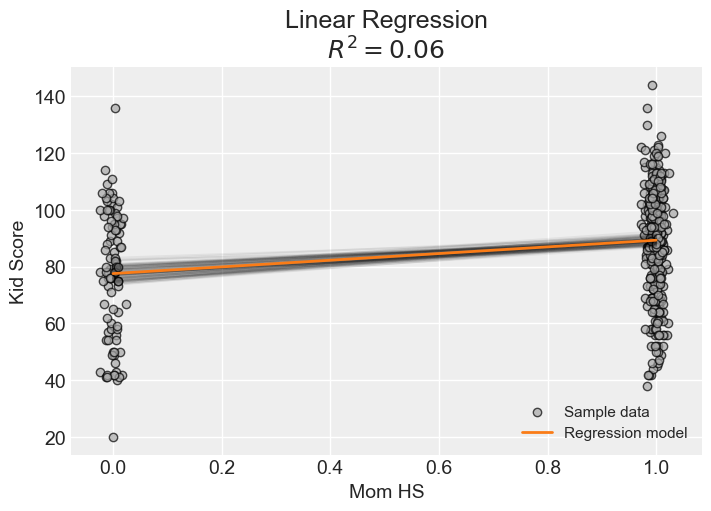

In [79]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

num_samples = 100

x_axis = xr.DataArray(np.linspace(0, 1, num=num_samples), dims=["x_plot"])
mu_pred = m2b_fit.posterior["Intercept"] + m2b_fit.posterior["mom_hs"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw")) # az.extract(mu_pred, num_samples=num_samples) # mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m2b_fit_r2_score.iloc[0], fontsize=18);

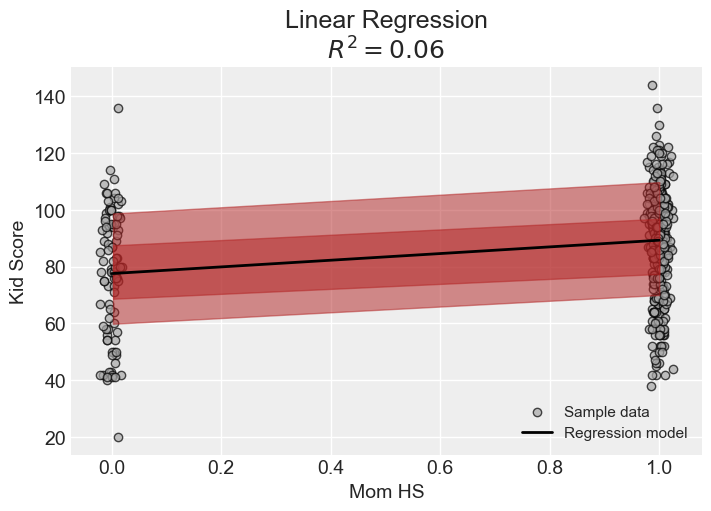

In [80]:
# SOURCE: https://bambinos.github.io/bambi/main/notebooks/t_regression.html
fig, ax = plt.subplots(figsize=(7, 5))

# Plot data
ax.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')


# Plot linear regression
x_range = np.linspace(min(kidiq.mom_hs), max(kidiq.mom_hs), 2000)
y_pred = m2b_fit.posterior.mom_hs.values.mean() * x_range + m2b_fit.posterior.Intercept.values.mean()
plt.plot(x_range, y_pred, color='k',linestyle='-', lw=2.0, label='Regression model')

# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(kidiq.mom_hs, m2b_fit.posterior_predictive.kid_score,
                hdi_prob=interval, color='firebrick')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m2b_fit_r2_score.iloc[0], fontsize=18);

---

# A continuous variable

In [81]:
sns.set_style("whitegrid")

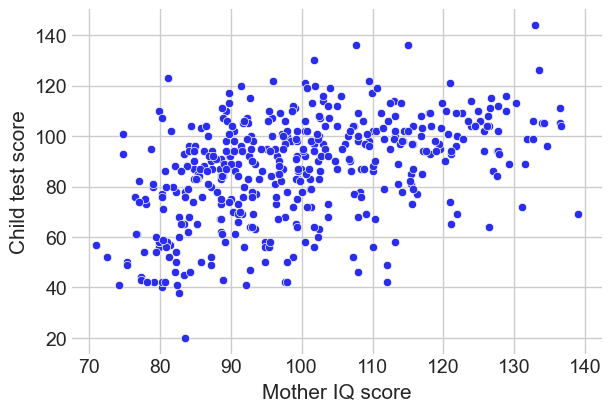

In [82]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="mom_iq", y="kid_score", data=kidiq, ax=ax)
plt.xlabel('Mother IQ score')
plt.ylabel('Child test score');

## Plot model

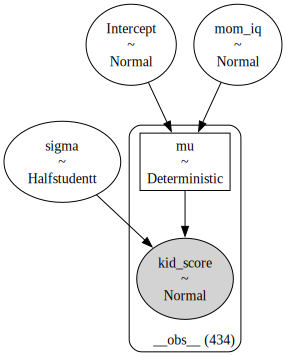

In [16]:
m3 = bmb.Model('kid_score ~ 1 + mom_iq', data=kidiq)

m3.build()

m3.graph()

In [17]:
m3

       Formula: kid_score ~ 1 + mom_iq
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 343.9751)
            mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [85]:
az.style.use(['arviz-whitegrid', 'arviz-orangish'])

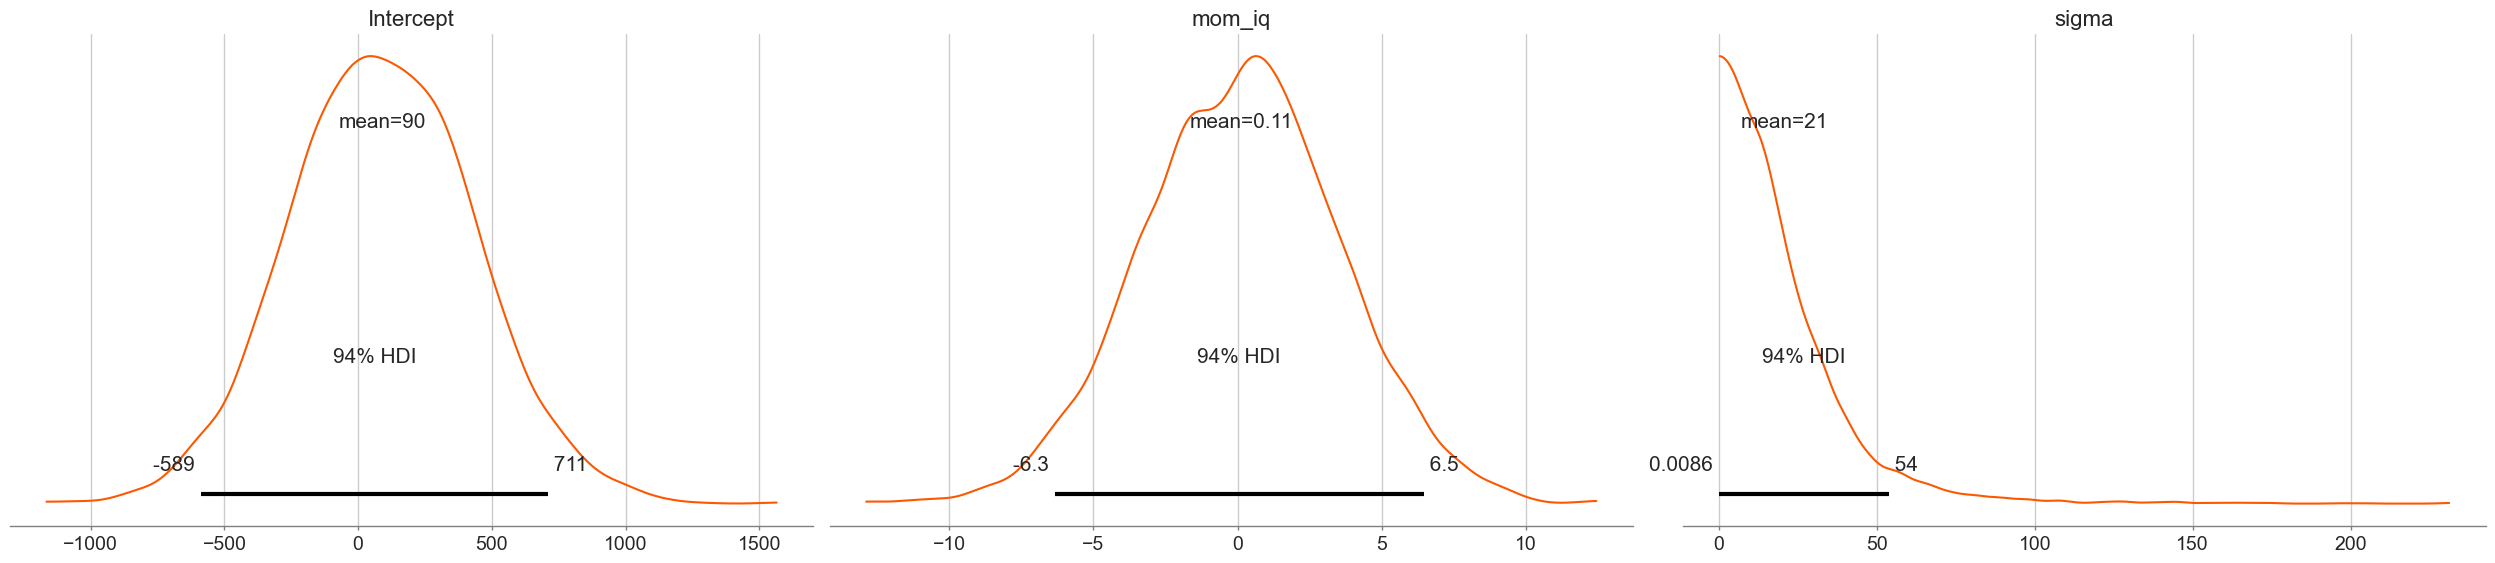

In [86]:
m3.plot_priors(var_names=['Intercept', 'mom_iq', 'sigma']);

## Fit model

In [18]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m3_fit = m3.fit(idata_kwargs=dict(log_likelihood=True))

m3_fit

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

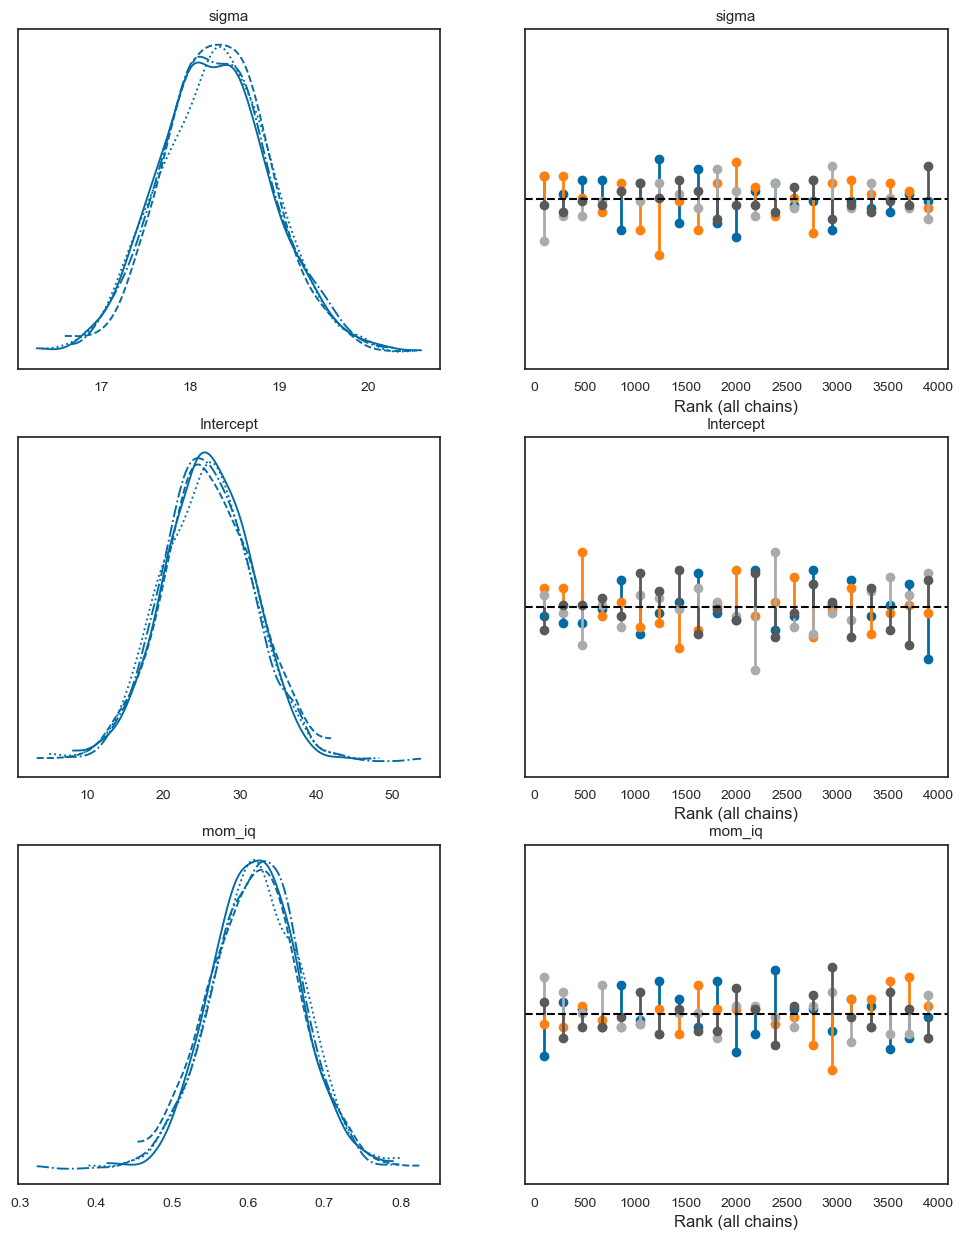

In [20]:
az.plot_trace(m3_fit, kind="rank_vlines", figsize=(12,15));

## Plot posterior distributions

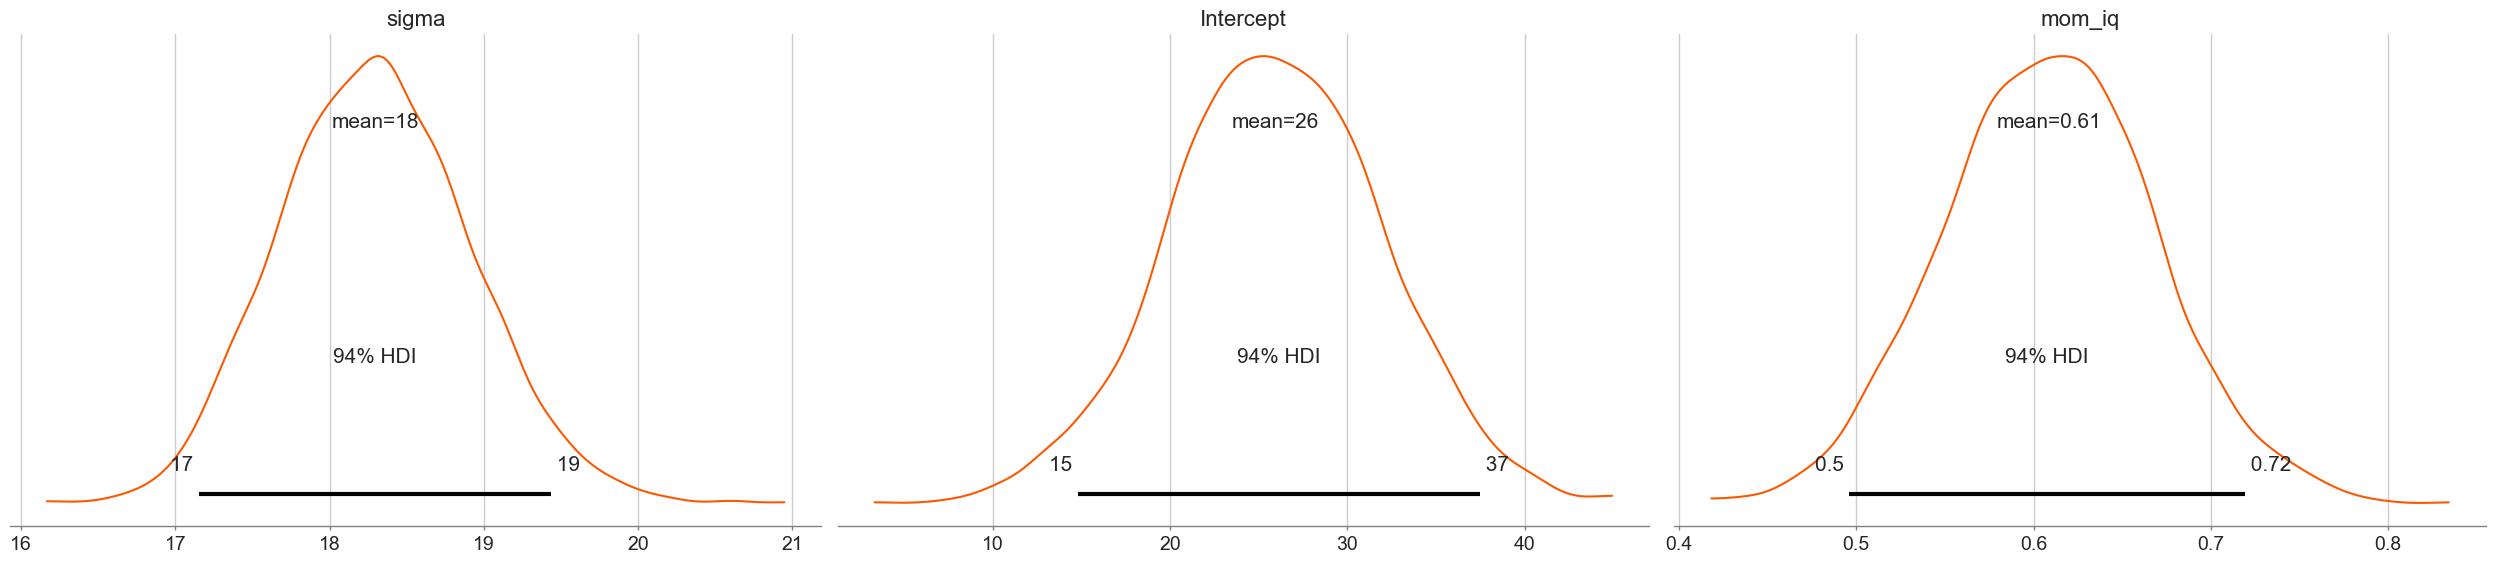

In [89]:
az.plot_posterior(m3_fit);

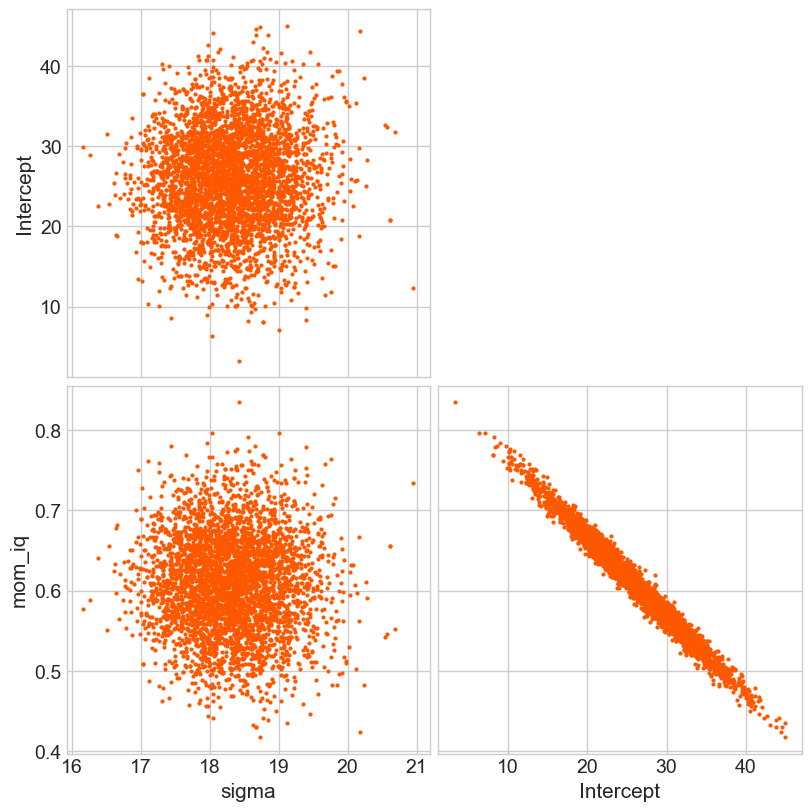

In [90]:
az.plot_pair(m3_fit, figsize=(8,8));

In [91]:
m3_df = az.extract(m3_fit).to_dataframe()[['Intercept', 'mom_iq', 'sigma']]
m3_df

Intercept    mom_iq      sigma
chain draw                                
0     0     36.630985  0.480715  17.265208
      1     34.723579  0.509021  17.789983
      2     20.342621  0.676847  17.772888
      3     31.546866  0.541183  18.753860
      4     26.860215  0.596681  17.758956
...               ...       ...        ...
3     995   14.972746  0.717322  17.133852
      996   36.151114  0.516893  19.751849
      997   34.374170  0.518710  19.439666
      998   27.656976  0.610804  18.605202
      999   27.656976  0.610804  18.605202

[4000 rows x 3 columns]

In [92]:
m3_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
Intercept  4000.0  25.92  6.01   3.28  21.88  25.90  30.01  44.98
mom_iq     4000.0   0.61  0.06   0.42   0.57   0.61   0.65   0.83
sigma      4000.0  18.30  0.62  16.16  17.87  18.29  18.71  20.95

## Interpret results

In [93]:
az.summary(m3_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma      18.3  0.6    17.2     19.4        0.0      0.0    5457.0    3304.0   
Intercept  25.9  6.0    14.8     37.5        0.1      0.1    5696.0    3128.0   
mom_iq      0.6  0.1     0.5      0.7        0.0      0.0    5689.0    3209.0   

           r_hat  
sigma        1.0  
Intercept    1.0  
mom_iq       1.0

In [94]:
posterior_predictive = m3.predict(m3_fit, kind="response")
m3_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

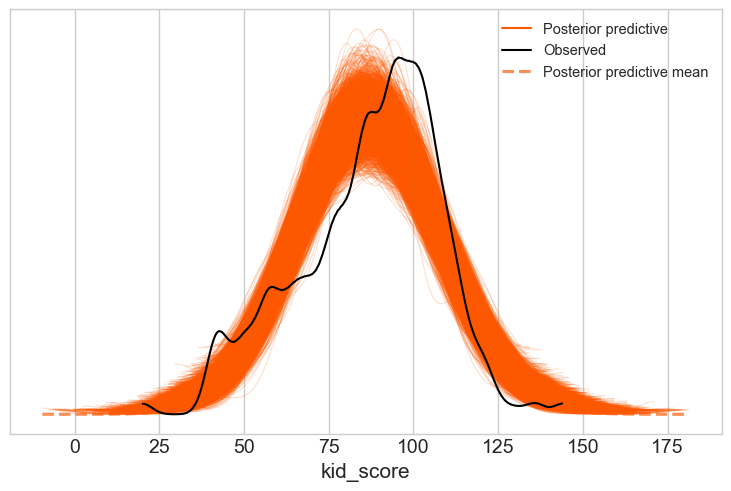

In [95]:
az.plot_ppc(m3_fit);

In [96]:
loo3 = az.loo(m3_fit)
loo3

Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1878.66    14.48
p_loo        2.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      434  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [97]:
y_true = kidiq.kid_score.values
y_pred = m3_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m3_fit_r2_score = az.r2_score(y_true, y_pred)
m3_fit_r2_score

r2        0.200239
r2_std    0.000000
dtype: float64

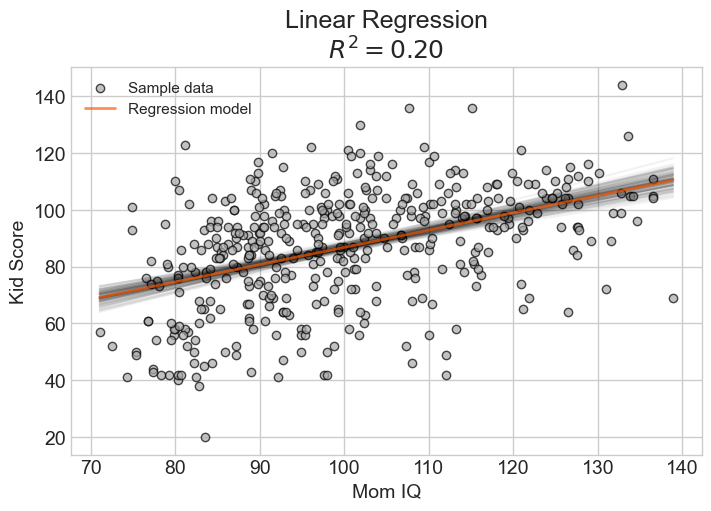

In [98]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
mu_pred = m3_fit.posterior["Intercept"] + m3_fit.posterior["mom_iq"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m3_fit_r2_score.iloc[0], fontsize=18);

---

## Two predictors: one binary and one continuous (no interaction)

In [99]:
sns.set_theme()

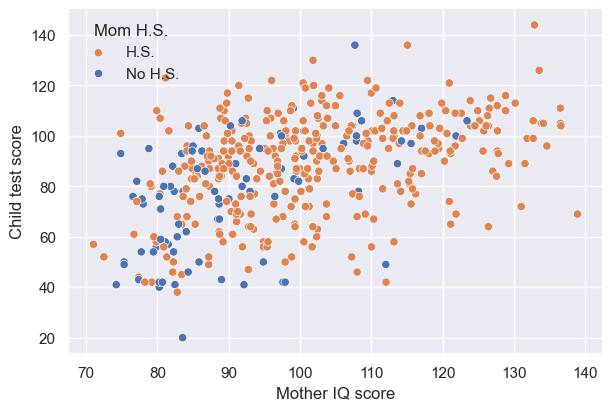

In [100]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=kidiq, x="mom_iq", y="kid_score", hue="mom_hs", ax=ax)
plt.legend(title='Mom H.S.', loc='upper left', labels=['H.S.', 'No H.S.'])
plt.xlabel('Mother IQ score')
plt.ylabel('Child test score');

## Plot model

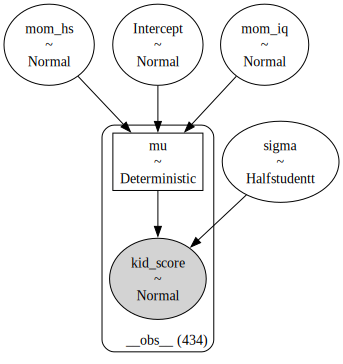

In [101]:
m4 = bmb.Model('kid_score ~ 1 + mom_hs + mom_iq', data=kidiq)

m4.build()

m4.graph()

In [102]:
m4

       Formula: kid_score ~ 1 + mom_hs + mom_iq
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 357.5526)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
            mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [103]:
az.style.use(['arviz-white', 'arviz-purplish'])

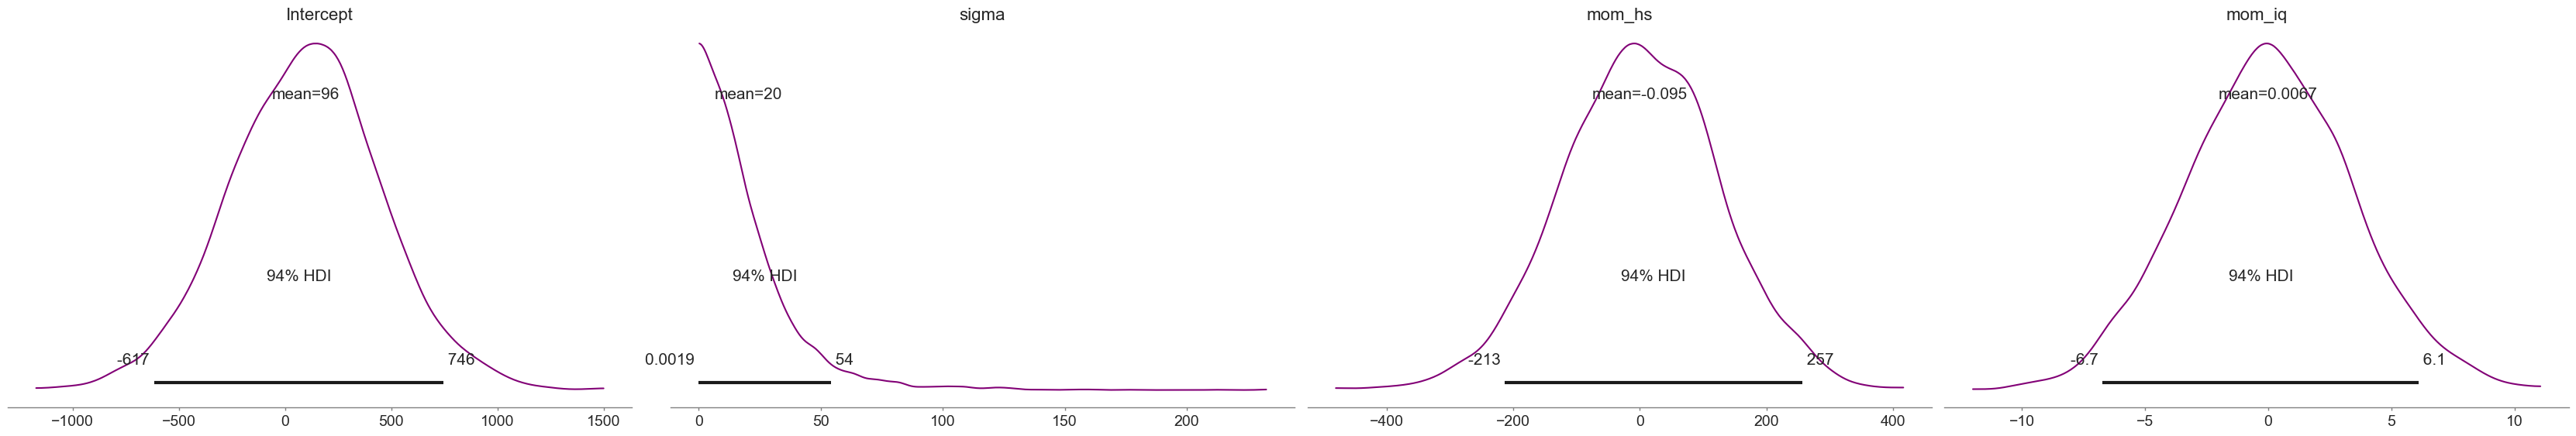

In [104]:
m4.plot_priors();

## Fit model

In [105]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m4_fit = m4.fit(idata_kwargs=dict(log_likelihood=True))

m4_fit

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

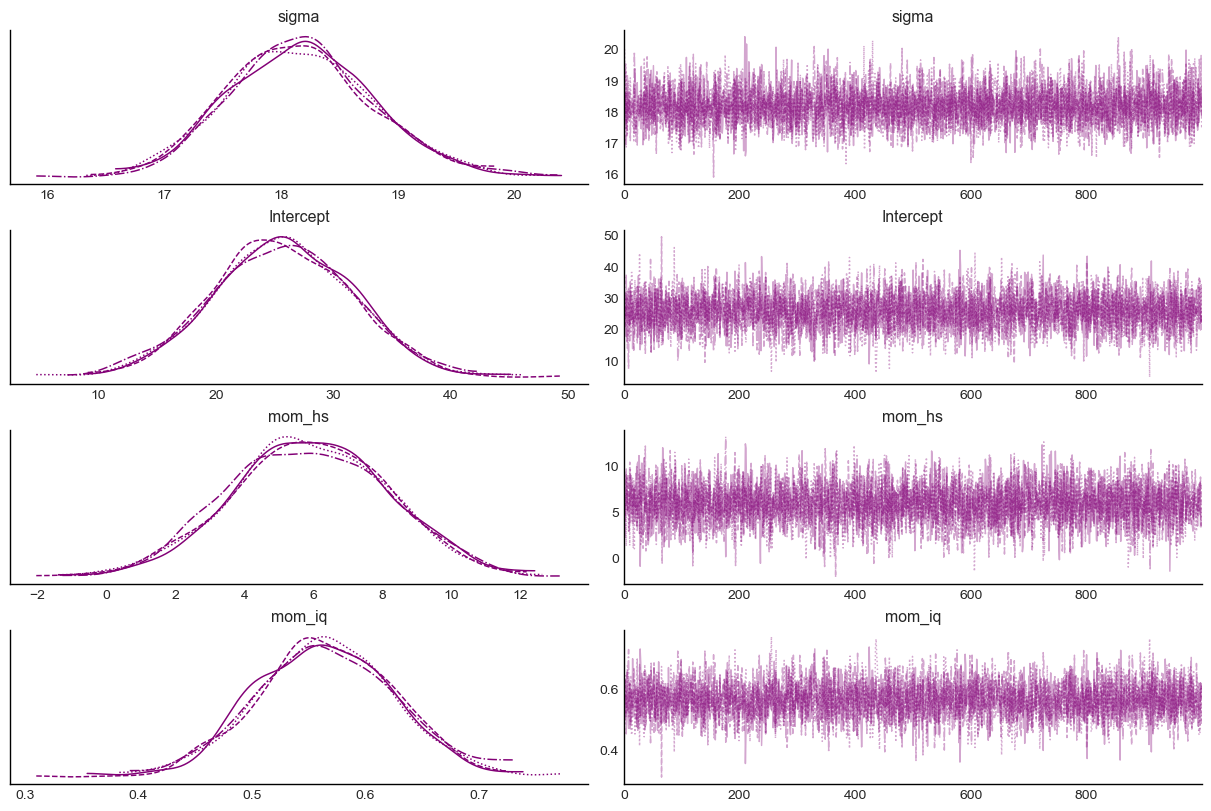

In [106]:
az.plot_trace(m4_fit, figsize=(12,8));

## Plot posterior distributions

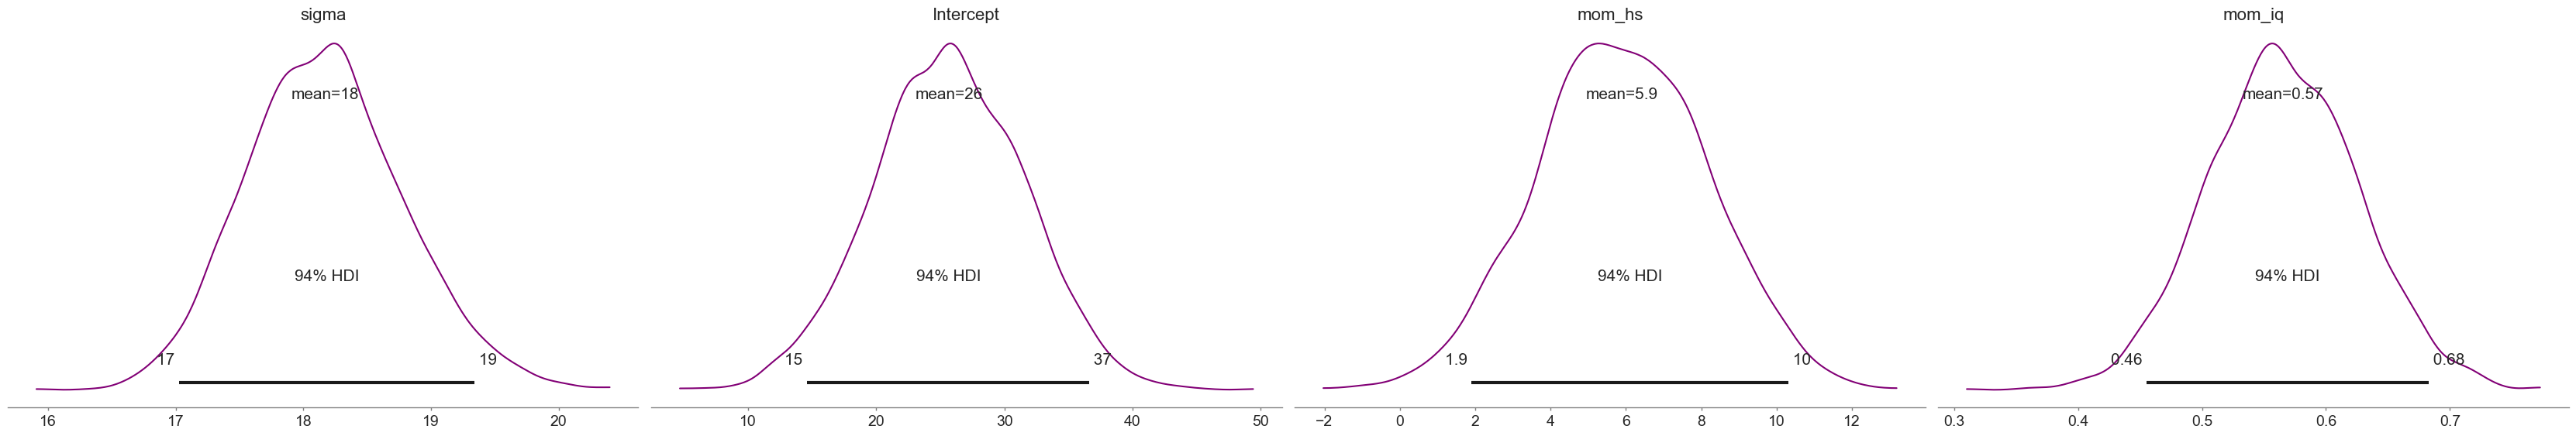

In [107]:
az.plot_posterior(m4_fit);

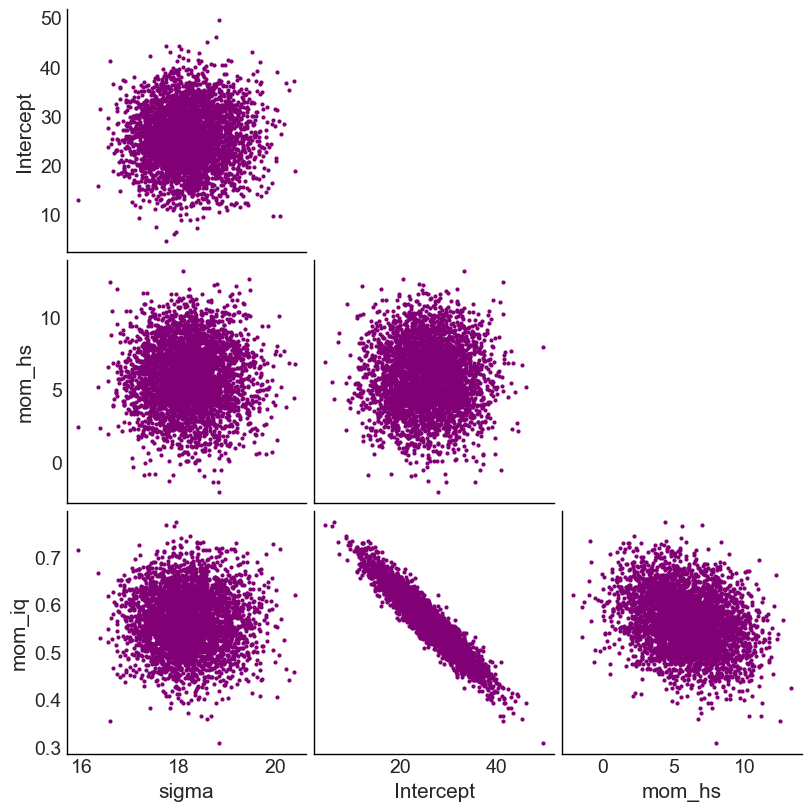

In [108]:
az.plot_pair(m4_fit, figsize=(8,8));

In [109]:
m4_df = az.extract(m4_fit).to_dataframe()[['Intercept', 'mom_hs', 'mom_iq', 'sigma']]
m4_df

Intercept    mom_hs    mom_iq      sigma
chain draw                                          
0     0     22.958573  7.202972  0.559692  17.642701
      1     21.498019  3.253159  0.632774  17.924455
      2     27.340076  5.956747  0.543069  18.445803
      3     31.519217  7.703731  0.508566  18.605107
      4     23.757669  9.068227  0.561667  17.629325
...               ...       ...       ...        ...
3     995   23.417646  6.807467  0.588479  18.736410
      996   28.358742  4.749929  0.527657  18.514481
      997   21.830562  4.764085  0.620065  18.198048
      998   22.713225  5.052105  0.607161  19.800760
      999   26.245419  5.155976  0.567123  17.497494

[4000 rows x 4 columns]

In [110]:
m4_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
Intercept  4000.0  25.67  5.89   4.65  21.74  25.67  29.80  49.45
mom_hs     4000.0   5.89  2.26  -2.05   4.35   5.88   7.48  13.20
mom_iq     4000.0   0.57  0.06   0.31   0.52   0.56   0.61   0.77
sigma      4000.0  18.17  0.62  15.90  17.75  18.16  18.56  20.40

## Interpret results

In [111]:
az.summary(m4_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma      18.2  0.6    17.0     19.3        0.0      0.0    5922.0    3711.0   
Intercept  25.7  5.9    14.6     36.6        0.1      0.1    4854.0    3177.0   
mom_hs      5.9  2.3     1.9     10.3        0.0      0.0    5302.0    3188.0   
mom_iq      0.6  0.1     0.5      0.7        0.0      0.0    4434.0    3402.0   

           r_hat  
sigma        1.0  
Intercept    1.0  
mom_hs       1.0  
mom_iq       1.0

In [112]:
posterior_predictive = m4.predict(m4_fit, kind="response")
m4_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

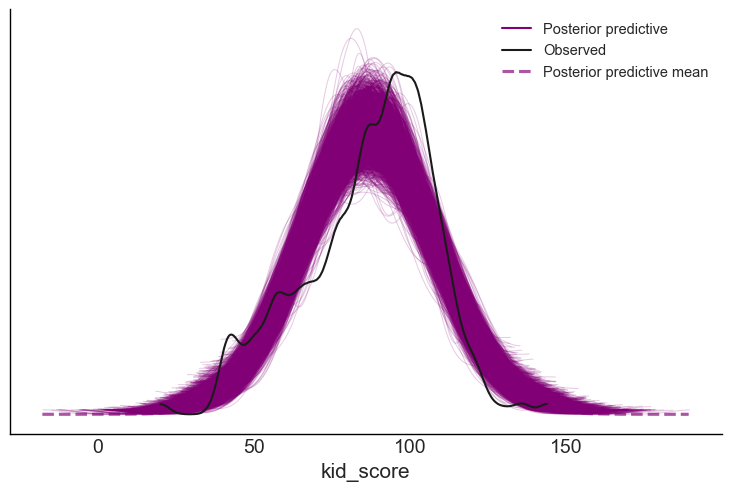

In [113]:
az.plot_ppc(m4_fit);

In [114]:
loo4 = az.loo(m4_fit)
loo4

Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1876.10    14.21
p_loo        4.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      434  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [115]:
y_true = kidiq.kid_score.values
y_pred = m4_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m4_fit_r2_score = az.r2_score(y_true, y_pred)
m4_fit_r2_score

r2        0.215444
r2_std    0.000000
dtype: float64

## Version 1: Plot data and fitted regression ("by hand")

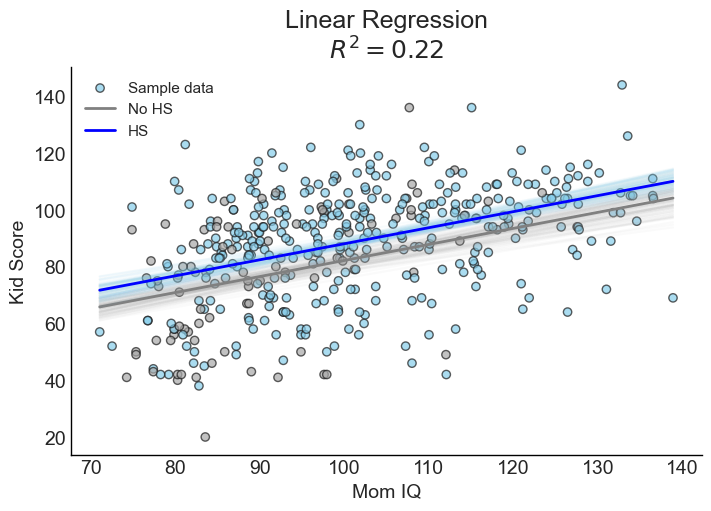

In [116]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)


fig, ax = plt.subplots(figsize=(7, 5))

colors = {1:'skyblue', 0:'darkgray'}

# Scatter plot of data points (color by value of mom_hs)
x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor=kidiq.mom_hs.map(colors), alpha=0.7, label='Sample data')

# No HS: Posterior regression lines
mu_pred_no_hs = m4_fit.posterior["Intercept"] + m4_fit.posterior["mom_iq"] * x_axis
mu_mean_no_hs = mu_pred_no_hs.mean(dim=("chain", "draw"))
mu_plot_no_hs = mu_pred_no_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_no_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_no_hs.isel(sample=random_subset), color="darkgray", alpha=0.05)
plt.plot(x_axis, mu_mean_no_hs, color="gray", lw=2.0, label='No HS')

# HS: Posterior regression lines
mu_pred_hs = (m4_fit.posterior["Intercept"]+m4_fit.posterior["mom_hs"]) + m4_fit.posterior["mom_iq"] * x_axis
mu_mean_hs = mu_pred_hs.mean(dim=("chain", "draw"))
mu_plot_hs = mu_pred_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_hs.isel(sample=random_subset), color="skyblue", alpha=0.05)
plt.plot(x_axis, mu_mean_hs, color="blue", lw=2.0, label='HS')

# Plot title and axis labels
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m4_fit_r2_score.iloc[0], fontsize=18);

## Version 2: Plot data and fitted regression (using [bambi's `interpret`](https://bambinos.github.io/bambi/notebooks/plot_predictions.html))

Default computed for conditional variable: mom_iq, mom_hs


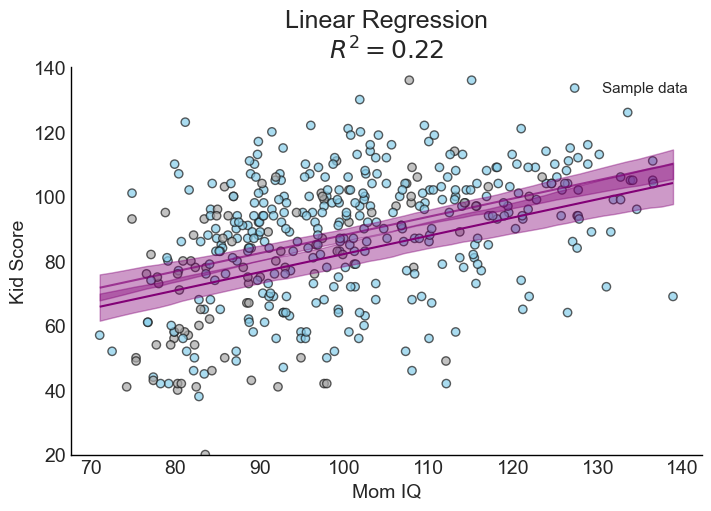

In [117]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor=kidiq.mom_hs.map(colors), alpha=0.7, label='Sample data')

bmb.interpret.plot_predictions(m4, m4_fit, ["mom_iq", "mom_hs"], ax=ax)

# Plot title and axis labels
ax.set_ylim(20, 140)
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m4_fit_r2_score.iloc[0], fontsize=18);

---

# Compare models

In [118]:
compare_dict = {"Model 1": loo1,
                "Model 2": loo2,
                "Model 3": loo3,
                "Model 4": loo4}

az.compare(compare_dict).round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
Model 4     0  -1876.10   4.07       0.00    0.80  14.21  0.00    False   log
Model 3     1  -1878.66   2.99       2.55    0.18  14.48  2.77    False   log
Model 2     2  -1914.85   3.11      38.75    0.02  13.78  8.36    False   log
Model 1     3  -1926.20   1.87      50.10    0.00  14.16  9.41    False   log

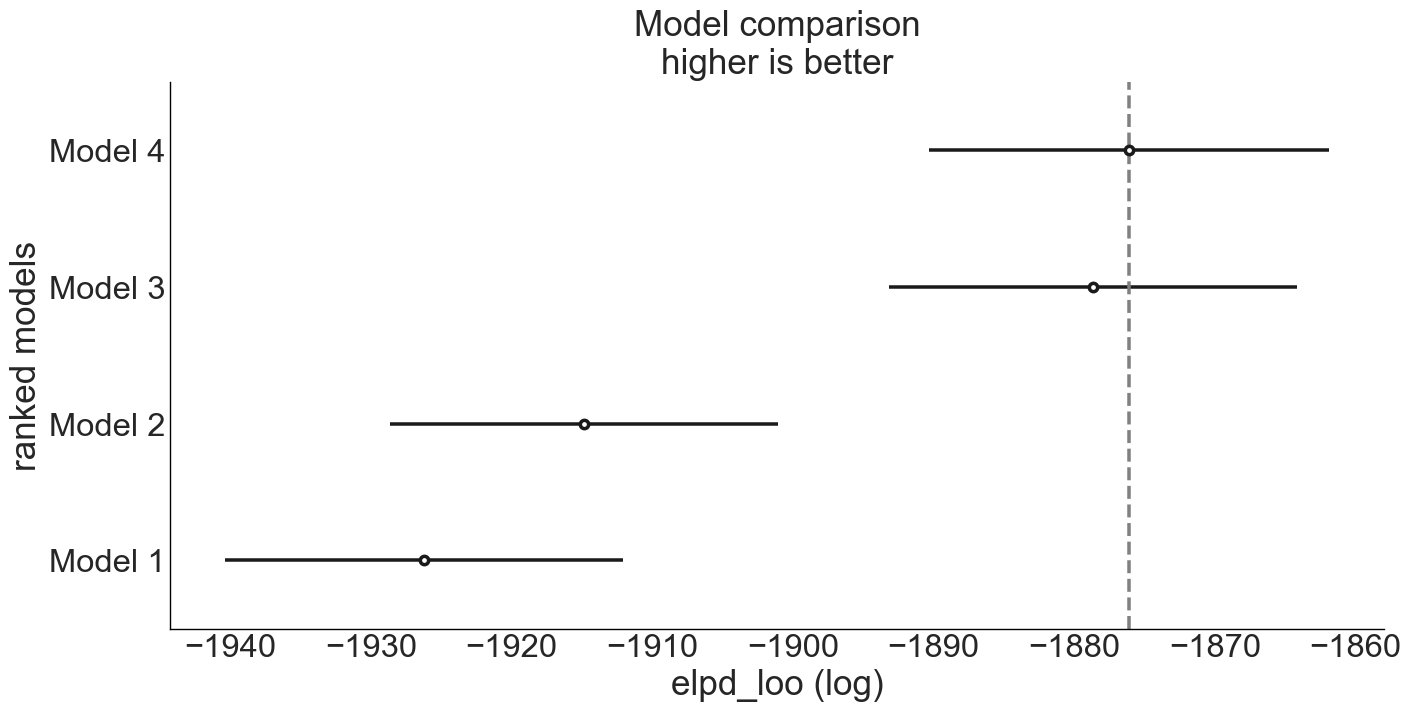

In [119]:
az.plot_compare(az.compare(compare_dict), figsize=(14, 7));

---

# Predict Outcomes for New Observations

In [120]:
import xarray as xr

xr.set_options(display_expand_data=False, display_expand_attrs=False);

`display_expand_data=False` makes the default view for `xarray.DataArray` fold the data values to a single line. To explore the values, click on the icon on the left of the view, right under the `xarray.DataArray` text. It has no effect on `Dataset` objects that already default to folded views.

`display_expand_attrs=False` folds the attributes in both `DataArray` and `Dataset` objects to keep the views shorter. Here, we print `DataArrays` and `Datasets` several times and they always have the same attributes.

In [121]:
kidiq[['mom_hs', 'mom_iq']].describe().round(1).T

count   mean   std   min   25%   50%    75%    max
mom_hs  434.0    0.8   0.4   0.0   1.0   1.0    1.0    1.0
mom_iq  434.0  100.0  15.0  71.0  88.7  97.9  110.3  138.9

### Point prediction (like `predict()` in R)

We'll create a few reasonable new observations:

In [122]:
# --- Define New Data for Prediction ---
# These are the new observations for which we want to predict 'kid_score'.
new_observations = pd.DataFrame({
    'mom_hs': [0., 0., 0., 0., 0., 1, 1, 1, 1, 1],
    'mom_iq': [71., 88.7, 97.9, 110.3, 138.9, 71., 88.7, 97.9, 110.3, 138.9]
})

print("--- New Data for Prediction ---")
new_observations

--- New Data for Prediction ---


mom_hs  mom_iq
0     0.0    71.0
1     0.0    88.7
2     0.0    97.9
3     0.0   110.3
4     0.0   138.9
5     1.0    71.0
6     1.0    88.7
7     1.0    97.9
8     1.0   110.3
9     1.0   138.9

In [123]:
# --------------------------------------------------------------------------
# Prediction Type 1: Point Prediction
# This is the single "best guess" value, calculated using the mean
# of the posterior distributions of the model parameters.
# Analogous to `predict(M1, newdata=new)` in R.
# --------------------------------------------------------------------------

# --- Predict Outcomes for New Observations ---
# By default, the .predict() method modifies 'm4_fit' in-place and returns None.
# So we don't assign its output to a variable.
print("--- Generating Predictions ---")
m4.predict(idata=m4_fit, kind="response_params", data=new_observations, inplace=True)

# The mean predictions are now stored in the 'posterior' group
# within the 'm4_fit' InferenceData object.
# The variable is named 'mu', for the outcome variable, 'kid_score'.
predictions_posterior = m4_fit.posterior['mu']
predictions_posterior

--- Generating Predictions ---


<xarray.DataArray 'mu' (chain: 4, draw: 1000, __obs__: 10)> Size: 320kB
62.7 72.6 77.75 84.69 100.7 69.9 79.81 ... 105.0 71.67 81.71 86.92 93.96 110.2
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * __obs__  (__obs__) int64 80B 0 1 2 3 4 5 6 7 8 9

In [124]:
# The result is a distribution of predictions for each new observation.
# We can summarize these by taking the mean across all posterior samples.
predicted_means = predictions_posterior.mean(dim=("chain", "draw"))
predicted_means

<xarray.DataArray 'mu' (__obs__: 10)> Size: 80B
65.79 75.79 80.99 87.99 104.2 71.68 81.68 86.88 93.89 110.0
Coordinates:
  * __obs__  (__obs__) int64 80B 0 1 2 3 4 5 6 7 8 9

In [125]:
# Add the predicted means as a new column to our new_observations DataFrame.
new_observations['kid_score prediction(V1)'] = np.round( predicted_means.values , 1)

print("\n--- Predictions for New Data ---")
new_observations


--- Predictions for New Data ---


mom_hs  mom_iq  kid_score prediction(V1)
0     0.0    71.0                      65.8
1     0.0    88.7                      75.8
2     0.0    97.9                      81.0
3     0.0   110.3                      88.0
4     0.0   138.9                     104.2
5     1.0    71.0                      71.7
6     1.0    88.7                      81.7
7     1.0    97.9                      86.9
8     1.0   110.3                      93.9
9     1.0   138.9                     110.0

### Two methods in one code cell

In [126]:
# --------------------------------------------------------------------------
# Prediction Type 1: Point Prediction
# This is the single "best guess" value, calculated using the mean
# of the posterior distributions of the model parameters.
# Analogous to `predict(M1, newdata=new)` in R.
# --------------------------------------------------------------------------

# Method 1a: Using the .predict() method

# We predict the parameters of the response distribution ('mu' and 'sigma') using kind='response_params'
# and then take the mean of 'mu' (the linear predictor) for the point estimate.
response_params = m4.predict(m4_fit, data=new_observations, kind='response_params', inplace=False)
point_pred_bambi = response_params.posterior['mu'].mean(dim=('chain', 'draw'))
print("Point Prediction (using m4.predict):\n", np.round( point_pred_bambi.values , 3) )
new_observations['kid_score prediction(V2)'] = np.round( point_pred_bambi.values , 1)


# Method 1b: "Manual" calculation

# We extract the mean of the posterior for each parameter and plug them
# into the regression equation.
# Analogous to: y_point_pred <- a_hat + b_hat*as.numeric(new)
param_means = az.summary(m4_fit, kind='stats')
intercept_hat = param_means.loc['Intercept', 'mean']
mom_hs_hat = param_means.loc['mom_hs', 'mean']
mom_iq_hat = param_means.loc['mom_iq', 'mean']

point_pred_manual = (
    intercept_hat +
    mom_hs_hat * new_observations['mom_hs'] +
    mom_iq_hat * new_observations['mom_iq']
)
print("\nPoint Prediction (manual calculation):\n", np.round( point_pred_manual.values , 3))
new_observations['kid_score prediction(V3)'] = np.round( point_pred_manual.values , 1)
new_observations

Point Prediction (using m4.predict):
 [ 65.788  75.789  80.988  87.994 104.154  71.679  81.681  86.879  93.885
 110.046]

Point Prediction (manual calculation):
 [ 65.785  75.786  80.983  87.989 104.148  71.676  81.676  86.874  93.88
 110.04 ]


mom_hs  mom_iq  kid_score prediction(V1)  kid_score prediction(V2)  \
0     0.0    71.0                      65.8                      65.8   
1     0.0    88.7                      75.8                      75.8   
2     0.0    97.9                      81.0                      81.0   
3     0.0   110.3                      88.0                      88.0   
4     0.0   138.9                     104.2                     104.2   
5     1.0    71.0                      71.7                      71.7   
6     1.0    88.7                      81.7                      81.7   
7     1.0    97.9                      86.9                      86.9   
8     1.0   110.3                      93.9                      93.9   
9     1.0   138.9                     110.0                     110.0   

   kid_score prediction(V3)  
0                      65.8  
1                      75.8  
2                      81.0  
3                      88.0  
4                     104.1  
5                      71.7  
6                      81.7  
7                      86.9  
8                      93.9  
9                     110.0

### Linear predictor with uncertainty (like `posterior_linpred()` in R)

We'll use the same 10 new observations in `new_observations`:

In [127]:
# --------------------------------------------------------------------------
# Prediction Type 2: Linear Predictor with Uncertainty
# This represents the uncertainty around the estimated regression line (E[y|x]).
# It doesn't include the observation noise (sigma).
# Analogous to `posterior_linpred(M1, newdata=new)` in R.
# --------------------------------------------------------------------------

# Method 2a: Using the .predict() method with kind='response_params'

# This returns the full posterior distribution of the linear predictor ('mu')
# and other response parameters (e.g., 'sigma').
linpred_idata = m4.predict(m4_fit, data=new_observations, kind='response_params', inplace=False)

# We extract just the 'mu' component, which represents the linear predictor.
# az.extract stacks the chains and draws into a single dimension.
linpred_draws = az.extract(linpred_idata)['mu']

print("Shape of Linear Predictor draws (using m4.predict):", linpred_draws.shape)
print("First 5 draws for the two newdata points:\n", linpred_draws.values[:5, :])

# Calculate 10 means
# The `axis=1` argument computes the mean across the columns,
# resulting in an array of 10 means.
means = np.mean(linpred_draws.values, axis=1)

# Calculate 10 standard deviations
# Similarly, `axis=1` computes the standard deviation across the columns,
# returning an array of 10 standard deviations.
stds = np.std(linpred_draws.values, axis=1)

# Print the results
print("\nMeans for each of the 10 rows:")
print(np.round(means,2))
print("\nStandard deviations for each of the 10 rows:")
print(np.round(stds,2))


# Method 2b: "Manual" calculation

# We use the full posterior draws for each parameter.
# Analogous to: y_linpred <- a + b*as.numeric(new)
posterior_draws = az.extract(m4_fit)

# We extract the underlying numpy arrays using .values to allow for
# numpy-style broadcasting with np.newaxis.
intercept_draws = posterior_draws['Intercept'].values
mom_hs_draws = posterior_draws['mom_hs'].values
mom_iq_draws = posterior_draws['mom_iq'].values

# Use broadcasting to calculate the linear predictor for each draw
linpred_manual = (
    intercept_draws[:, np.newaxis] +
    mom_hs_draws[:, np.newaxis] * new_observations['mom_hs'].values +
    mom_iq_draws[:, np.newaxis] * new_observations['mom_iq'].values
)

print("\nShape of Linear Predictor draws (manual calculation):", linpred_manual.T.shape) # Transpose rows and columnns
print("First 5 draws for the two newdata points (manual):\n", linpred_manual.T[:5, :])

# Calculate 10 means
means = np.mean(linpred_manual.T, axis=1)

# Calculate 10 standard deviations
stds = np.std(linpred_manual.T, axis=1)

# Print the results
print("\nMeans for each of the 10 rows:")
print(np.round(means,2))
print("\nStandard deviations for each of the 10 rows:")
print(np.round(stds,2))

Shape of Linear Predictor draws (using m4.predict): (10, 4000)
First 5 draws for the two newdata points:
 [[ 62.69672192  66.42499512  65.89796225 ...  65.85516429  65.82165706
   66.51112757]
 [ 72.60327445  77.62510044  75.51028029 ...  76.83031168  76.56840694
   76.54919861]
 [ 77.75244299  83.44662411  80.50651339 ...  82.53490807  82.15428823
   81.76672706]
 [ 84.69262668  91.29302558  87.2405667  ...  90.2237119   89.68308475
   88.79904801]
 [100.69982454 109.3903709  102.77233482 ... 107.95756588 107.04788964
  105.01875602]]

Means for each of the 10 rows:
[ 65.79  75.79  80.99  87.99 104.15  71.68  81.68  86.88  93.89 110.05]

Standard deviations for each of the 10 rows:
[2.27 1.9  1.93 2.21 3.45 2.17 1.32 1.06 1.13 2.44]

Shape of Linear Predictor draws (manual calculation): (10, 4000)
First 5 draws for the two newdata points (manual):
 [[ 62.69672192  66.42499512  65.89796225 ...  65.85516429  65.82165706
   66.51112757]
 [ 72.60327445  77.62510044  75.51028029 ...  76.83

### Predictive distribution for new observations (like `posterior_predict()` in R)

We'll use the same 10 new observations in `new_observations`:

In [128]:
# --------------------------------------------------------------------------
# Prediction Type 3: Predictive Distribution for a New Observation
# This represents the full uncertainty for a *new data point*. It includes
# both uncertainty in the parameter estimates AND the inherent observation
# noise/error (sigma). The resulting distribution is wider than the
# linear predictor.
# Analogous to `posterior_predict(M1, newdata=new)` in R.
# --------------------------------------------------------------------------

# Method 3a: Using the .predict() method with kind='response'

# 'response' generates samples from the posterior predictive distribution.
pred_dist_idata = m4.predict(m4_fit, data=new_observations, kind='response', inplace=False)

# # az.extract stacks the chains and draws into a single dimension.
pred_dist_draws = az.extract(pred_dist_idata.posterior_predictive)['kid_score']

print("Shape of Posterior Predictive draws (using m4.predict):", pred_dist_draws.shape)
print("First 5 draws for the two newdata points:\n", pred_dist_draws.values[:5, :])

# Calculate 10 means
# The `axis=1` argument computes the mean across the columns,
# resulting in an array of 10 means.
means = np.mean(pred_dist_draws.values, axis=1)

# Calculate 10 standard deviations
# Similarly, `axis=1` computes the standard deviation across the columns,
# returning an array of 10 standard deviations.
stds = np.std(pred_dist_draws.values, axis=1)

# Print the results
print("\nMeans for each of the 10 rows:")
print(np.round(means,2))
print("\nStandard deviations for each of the 10 rows:")
print(np.round(stds,2))


# Method 3b: "Manual" calculation

# We take the manually calculated linear predictor and add random noise
# sampled using the posterior draws of sigma.
# Analogous to: y_pred <- a + b*as.numeric(new) + rnorm(n_sims, 0, sigma)
sigma_draws = posterior_draws['sigma'].values
n_draws = len(sigma_draws)
n_new_observations = len(new_observations)

# Generate random normal noise for each draw and each new data point
noise = np.random.normal(0, sigma_draws[:, np.newaxis], size=(n_draws, n_new_observations))

# Add the noise to the linear predictor
pred_dist_manual = linpred_manual + noise
print("\nShape of Posterior Predictive draws (manual calculation):", pred_dist_manual.shape)
print("First 5 draws for the two newdata points (manual):\n", pred_dist_manual[:5, :])

# You can verify that the standard deviation of the posterior predictive
# distribution is larger than that of the linear predictor.
print("\n--- Comparison of Uncertainty ---")
print("Std. Dev. of Linear Predictor (mom_hs=1):", np.round( linpred_manual[:, 1].std() , 2) )
print("Std. Dev. of Posterior Predictive (mom_hs=1):", np.round( pred_dist_manual[:, 1].std() , 2) )

Shape of Posterior Predictive draws (using m4.predict): (10, 4000)
First 5 draws for the two newdata points:
 [[ 52.55750874  65.34867426  54.11842009 ...  66.44806606  77.46553403
   56.60150989]
 [ 77.74822194  59.85842707  89.37522631 ...  70.41455924  71.2237763
   61.6554256 ]
 [ 65.55496817  85.78488356  65.32752183 ... 104.02599309  73.11927004
   76.60575141]
 [ 82.20049583  80.80963321 120.68639576 ...  99.24687461  97.55843935
   38.24792974]
 [ 99.65887479  79.86910334  85.36231319 ... 112.67482058 109.43648929
   84.95688983]]

Means for each of the 10 rows:
[ 65.79  75.56  81.11  88.21 103.71  71.74  82.29  86.94  93.83 110.35]

Standard deviations for each of the 10 rows:
[18.11 18.02 18.14 18.51 18.51 18.3  18.45 18.19 18.17 18.15]

Shape of Posterior Predictive draws (manual calculation): (4000, 10)
First 5 draws for the two newdata points (manual):
 [[ 57.4521853   72.71087255  75.52185013  65.81239989  68.91713073
   56.69315282  79.15670776  98.2954066   81.74218578 


Generating plot to visualize uncertainty...

Plot generated. Notice the red error bars (Posterior Predictive) are wider.


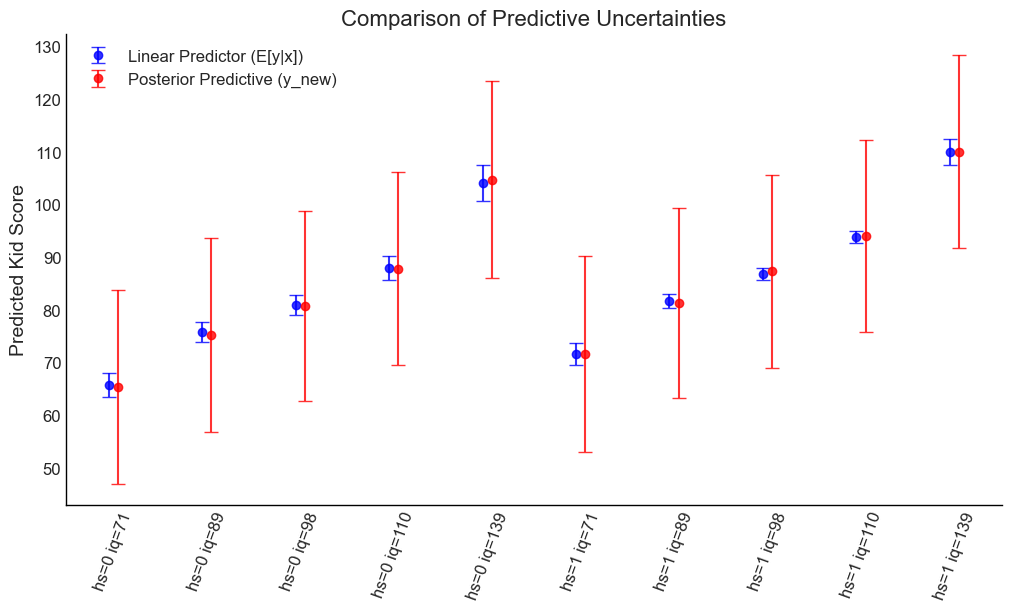

In [129]:
# --------------------------------------------------------------------------
# Plotting to Visualize the Difference in Uncertainty
# --------------------------------------------------------------------------
print("\nGenerating plot to visualize uncertainty...")

# Calculate means and standard deviations for both prediction types
linpred_means = linpred_manual.mean(axis=0)
linpred_stds = linpred_manual.std(axis=0)

pred_dist_means = pred_dist_manual.mean(axis=0)
pred_dist_stds = pred_dist_manual.std(axis=0)

# Create x-axis labels for the plot based on newdata
x_labels = [
    f"hs={int(vals['mom_hs'])} iq={round(vals['mom_iq'])}" 
    for i, vals in new_observations.loc[:, ['mom_hs', 'mom_iq']].iterrows()
]
x_pos = np.arange(len(x_labels))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Linear Predictor uncertainty (captures uncertainty in the regression line)
plt.errorbar(x_pos - 0.05, linpred_means, yerr=linpred_stds, fmt='o', capsize=5,
             label='Linear Predictor (E[y|x])', color='blue', alpha=0.8)

# Plot Posterior Predictive uncertainty (captures uncertainty for a new observation, y_new)
plt.errorbar(x_pos + 0.05, pred_dist_means, yerr=pred_dist_stds, fmt='o', capsize=5,
             label='Posterior Predictive (y_new)', color='red', alpha=0.8)

plt.xticks(x_pos, x_labels, fontsize=12, rotation=70)
plt.yticks(fontsize=12)
plt.ylabel("Predicted Kid Score", fontsize=14)
plt.title("Comparison of Predictive Uncertainties", fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7);

print("\nPlot generated. Notice the red error bars (Posterior Predictive) are wider.")

---

# Exercise:

### Estimate the relationship between `weight` and `height` in a sample of adults [[Source]](https://bookdown.org/content/4857/geocentric-models.html#linear-prediction)

### Read dataset into DataFrame

In [130]:
d = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2025ODSCWest/main/data/Howell1.csv', sep=';')

### Filter for adults

In [131]:
d2 = d[d.age >= 18]
d2

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

### Plot data

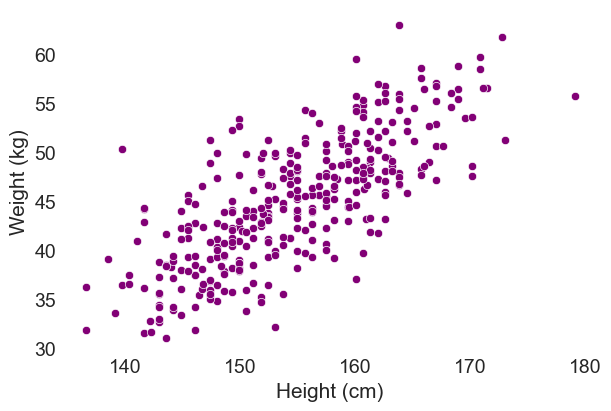

In [132]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="height", y="weight", data=d2, ax=ax)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)');

### Plot model

In [ ]:
m_weight = bmb.Model('', data= )

m_weight.build()

m_weight.graph()

In [ ]:
m_weight

### Plot prior parameter distributions

### Fit model

### Plot MCMC diagnostics

### Plot posterior distributions

### Interpret results

### Plot posterior predictive distribution

### Compute loo